<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

Так как проект выполняется локально, а не на платформе, будем использовать try-except, чтобы избежать ошибки при чтении файла: 

In [2]:
try: 
    data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0])

except:
    data = pd.read_csv('C:/Users/freak/Desktop/Python/ML_taxi_forecast_project/taxi.csv', index_col=0, parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Можно заметить отсутствие пропусков в данных. 

In [5]:
data = data.sort_index()

Согласно техническому заданию, данные необходимо ресемплировать по одному часу: 

In [6]:
data = data.resample('1H').sum()

## Анализ

Создадим признаки для горизонта прогнозирования. С помощью функции `make_features()` прибавим к таблице четыре новых календарных признака: год, месяц, день и день недели. Также вычислим максимальный размер отставания `max_lag` и скользящее среднее `rolling_mean`. 

In [7]:
def make_features(data, max_lag, rolling_mean_size): 
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [8]:
make_features(data, 100, 150)

C:\Users\freak\AppData\Local\Temp/ipykernel_9612/2836603629.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\freak\AppData\Local\Temp/ipykernel_9612/2836603629.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


С помощью графиков ознакомимся с трендами и сезонностью: 

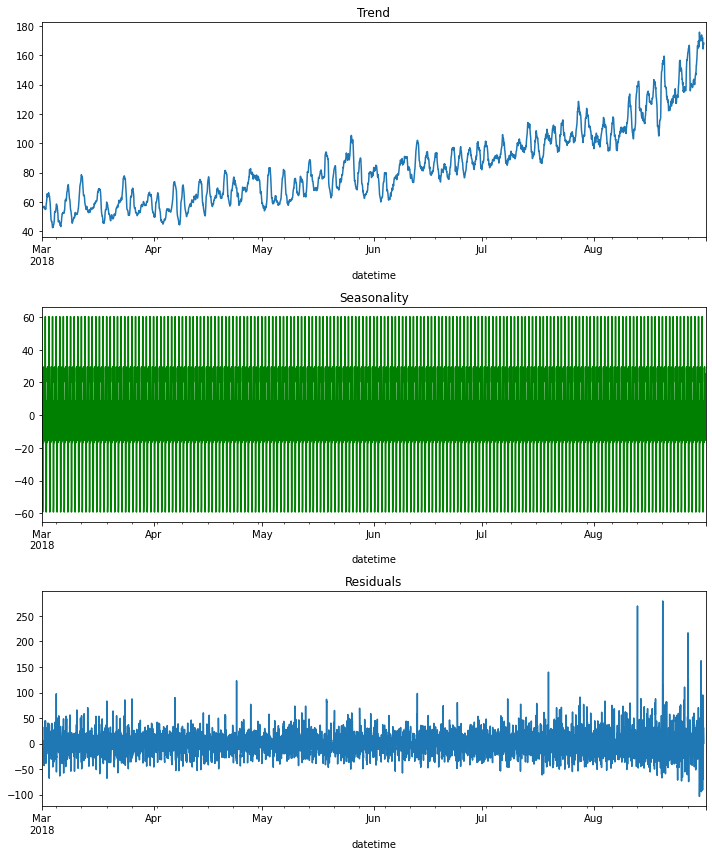

In [9]:
decomposed = seasonal_decompose(data['num_orders'])


plt.figure(figsize=(10, 12))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='g')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Построим аналогичные графики для небольшого промежутка времени: 

_Первая неделя марта_

Text(0.5, 1.0, 'Seasonality')

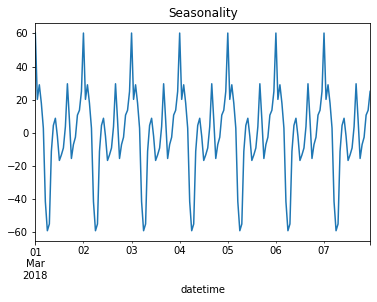

In [10]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality')

Text(0.5, 1.0, 'Trend')

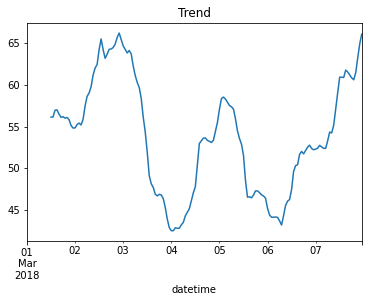

In [11]:
decomposed.trend['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Trend')

_Посдедняя неделя августа_

Text(0.5, 1.0, 'Seasonality')

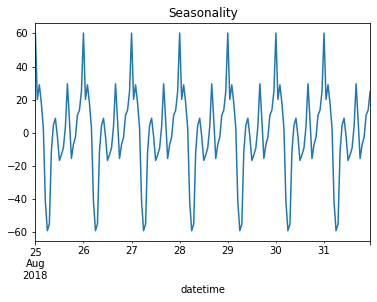

In [12]:
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')

Text(0.5, 1.0, 'Trend')

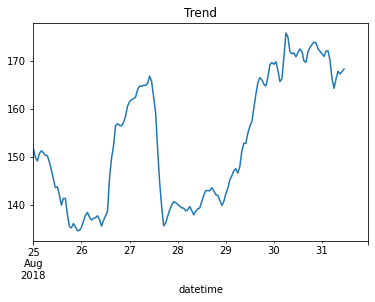

In [13]:
decomposed.trend['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')

Согласно графикам, в рамках исследуемого периода сезонность не изменяется. Также можно увидеть, что спрос на такси растер в начале дня, затем резко падает, а во второй половине дня снова начинает расти, достигая нового пика к концу дня. 

Посмотрим на гистрограмму количества заказов: 

<AxesSubplot:>

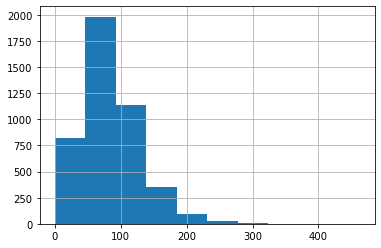

In [14]:
data['num_orders'].hist()

## Обучение

Согласно техническому заданию, размер тестовой выборки должен составлять 10% от исходных данных. 

In [16]:
train, test = train_test_split(data, shuffle = False, random_state = 123, test_size = 0.2)
valid, test = train_test_split(test, shuffle = False, random_state = 123, test_size = 0.5)
train = train.dropna()

In [17]:
features_train = train.drop(['num_orders'], axis = 1)
features_valid = valid.drop(['num_orders'], axis = 1)
features_test = test.drop(['num_orders'], axis = 1)

In [18]:
target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

In [19]:
print(train.shape)
print(test.shape)
print(valid.shape)
print(data.shape)

(3382, 105)
(442, 105)
(442, 105)
(4416, 105)


**Случайный лес**

In [20]:
splits = TimeSeriesSplit(n_splits=3)

random_forest = RandomForestRegressor(random_state=123)
parametrs = {'max_depth': [1, 10],'n_estimators':[100, 150, 10]}

random_forest_grid = GridSearchCV(random_forest, parametrs, cv = splits, verbose=True, n_jobs=-1)
random_forest_grid.fit(features_train, target_train)
random_forest_grid.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'max_depth': 10, 'n_estimators': 150}

**Catboost**

In [21]:
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 123)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1, 1, 0.2)}
catboost_grid = catboost.grid_search(parameters_cat, Pool(features_train,target_train), cv=splits, verbose=True)

0:	learn: 70.7041519	test: 98.7293325	best: 98.7293325 (0)	total: 178ms	remaining: 2m 58s
1:	learn: 64.7330208	test: 91.8834853	best: 91.8834853 (1)	total: 188ms	remaining: 1m 33s
2:	learn: 59.3399662	test: 85.6344936	best: 85.6344936 (2)	total: 198ms	remaining: 1m 5s
3:	learn: 54.7055404	test: 80.2711397	best: 80.2711397 (3)	total: 201ms	remaining: 50.1s
4:	learn: 50.4227905	test: 74.5948964	best: 74.5948964 (4)	total: 208ms	remaining: 41.4s
5:	learn: 46.6781698	test: 69.4769911	best: 69.4769911 (5)	total: 217ms	remaining: 35.9s
6:	learn: 43.4006480	test: 65.2336132	best: 65.2336132 (6)	total: 224ms	remaining: 31.8s
7:	learn: 40.6612872	test: 61.5814264	best: 61.5814264 (7)	total: 231ms	remaining: 28.7s
8:	learn: 38.0759250	test: 58.3834056	best: 58.3834056 (8)	total: 239ms	remaining: 26.3s
9:	learn: 35.7945165	test: 55.0115958	best: 55.0115958 (9)	total: 246ms	remaining: 24.4s
10:	learn: 33.7431914	test: 52.2061878	best: 52.2061878 (10)	total: 255ms	remaining: 22.9s
11:	learn: 31.947

106:	learn: 16.7299291	test: 26.8355732	best: 26.8077531 (100)	total: 746ms	remaining: 6.23s
107:	learn: 16.6708299	test: 26.7896197	best: 26.7896197 (107)	total: 752ms	remaining: 6.21s
108:	learn: 16.6296636	test: 26.7446871	best: 26.7446871 (108)	total: 757ms	remaining: 6.19s
109:	learn: 16.5965653	test: 26.7462944	best: 26.7446871 (108)	total: 762ms	remaining: 6.17s
110:	learn: 16.5604529	test: 26.6833709	best: 26.6833709 (110)	total: 768ms	remaining: 6.15s
111:	learn: 16.5048711	test: 26.6960611	best: 26.6833709 (110)	total: 775ms	remaining: 6.14s
112:	learn: 16.4714592	test: 26.6643902	best: 26.6643902 (112)	total: 781ms	remaining: 6.13s
113:	learn: 16.4206215	test: 26.6392250	best: 26.6392250 (113)	total: 786ms	remaining: 6.11s
114:	learn: 16.3675463	test: 26.6266512	best: 26.6266512 (114)	total: 792ms	remaining: 6.1s
115:	learn: 16.3070183	test: 26.5519357	best: 26.5519357 (115)	total: 797ms	remaining: 6.08s
116:	learn: 16.2700699	test: 26.5859635	best: 26.5519357 (115)	total: 8

219:	learn: 13.3976564	test: 26.6375176	best: 26.5026407 (184)	total: 1.28s	remaining: 4.56s
220:	learn: 13.3718437	test: 26.6296688	best: 26.5026407 (184)	total: 1.29s	remaining: 4.55s
221:	learn: 13.3517756	test: 26.6390967	best: 26.5026407 (184)	total: 1.29s	remaining: 4.54s
222:	learn: 13.3358581	test: 26.6376291	best: 26.5026407 (184)	total: 1.3s	remaining: 4.53s
223:	learn: 13.3068736	test: 26.6428475	best: 26.5026407 (184)	total: 1.3s	remaining: 4.52s
224:	learn: 13.2927674	test: 26.6411751	best: 26.5026407 (184)	total: 1.31s	remaining: 4.51s
225:	learn: 13.2616540	test: 26.6469985	best: 26.5026407 (184)	total: 1.31s	remaining: 4.5s
226:	learn: 13.2448018	test: 26.6423421	best: 26.5026407 (184)	total: 1.32s	remaining: 4.49s
227:	learn: 13.2218174	test: 26.6480980	best: 26.5026407 (184)	total: 1.32s	remaining: 4.48s
228:	learn: 13.1968122	test: 26.6490989	best: 26.5026407 (184)	total: 1.33s	remaining: 4.47s
229:	learn: 13.1643360	test: 26.6550787	best: 26.5026407 (184)	total: 1.3

331:	learn: 11.2159378	test: 26.5110731	best: 26.5026407 (184)	total: 1.82s	remaining: 3.67s
332:	learn: 11.2056243	test: 26.5096581	best: 26.5026407 (184)	total: 1.83s	remaining: 3.66s
333:	learn: 11.1862166	test: 26.4967712	best: 26.4967712 (333)	total: 1.83s	remaining: 3.65s
334:	learn: 11.1685264	test: 26.5117768	best: 26.4967712 (333)	total: 1.84s	remaining: 3.65s
335:	learn: 11.1599377	test: 26.5134599	best: 26.4967712 (333)	total: 1.84s	remaining: 3.64s
336:	learn: 11.1414736	test: 26.5163531	best: 26.4967712 (333)	total: 1.85s	remaining: 3.63s
337:	learn: 11.1178898	test: 26.5107075	best: 26.4967712 (333)	total: 1.85s	remaining: 3.63s
338:	learn: 11.1018042	test: 26.5051249	best: 26.4967712 (333)	total: 1.85s	remaining: 3.62s
339:	learn: 11.0837634	test: 26.4909099	best: 26.4909099 (339)	total: 1.86s	remaining: 3.61s
340:	learn: 11.0820084	test: 26.4924335	best: 26.4909099 (339)	total: 1.86s	remaining: 3.6s
341:	learn: 11.0609479	test: 26.4977041	best: 26.4909099 (339)	total: 1

462:	learn: 9.2489440	test: 26.3973472	best: 26.3882138 (460)	total: 2.38s	remaining: 2.77s
463:	learn: 9.2332495	test: 26.3930975	best: 26.3882138 (460)	total: 2.39s	remaining: 2.76s
464:	learn: 9.2143358	test: 26.3950130	best: 26.3882138 (460)	total: 2.39s	remaining: 2.75s
465:	learn: 9.2006402	test: 26.4058515	best: 26.3882138 (460)	total: 2.4s	remaining: 2.75s
466:	learn: 9.1889985	test: 26.4125424	best: 26.3882138 (460)	total: 2.4s	remaining: 2.74s
467:	learn: 9.1725545	test: 26.4194866	best: 26.3882138 (460)	total: 2.4s	remaining: 2.73s
468:	learn: 9.1603284	test: 26.4216102	best: 26.3882138 (460)	total: 2.41s	remaining: 2.73s
469:	learn: 9.1516361	test: 26.4056831	best: 26.3882138 (460)	total: 2.41s	remaining: 2.72s
470:	learn: 9.1379131	test: 26.3837125	best: 26.3837125 (470)	total: 2.42s	remaining: 2.71s
471:	learn: 9.1367026	test: 26.3838451	best: 26.3837125 (470)	total: 2.42s	remaining: 2.71s
472:	learn: 9.1269949	test: 26.3817377	best: 26.3817377 (472)	total: 2.42s	remainin

561:	learn: 7.9695262	test: 26.3998198	best: 26.3407737 (485)	total: 2.76s	remaining: 2.15s
562:	learn: 7.9597821	test: 26.3973173	best: 26.3407737 (485)	total: 2.76s	remaining: 2.14s
563:	learn: 7.9455594	test: 26.3924924	best: 26.3407737 (485)	total: 2.77s	remaining: 2.14s
564:	learn: 7.9322729	test: 26.3892946	best: 26.3407737 (485)	total: 2.77s	remaining: 2.13s
565:	learn: 7.9190508	test: 26.3924445	best: 26.3407737 (485)	total: 2.77s	remaining: 2.13s
566:	learn: 7.9040745	test: 26.3843792	best: 26.3407737 (485)	total: 2.78s	remaining: 2.12s
567:	learn: 7.8903939	test: 26.3789659	best: 26.3407737 (485)	total: 2.78s	remaining: 2.12s
568:	learn: 7.8754306	test: 26.3789858	best: 26.3407737 (485)	total: 2.78s	remaining: 2.11s
569:	learn: 7.8645806	test: 26.3889546	best: 26.3407737 (485)	total: 2.79s	remaining: 2.1s
570:	learn: 7.8502094	test: 26.3889115	best: 26.3407737 (485)	total: 2.79s	remaining: 2.1s
571:	learn: 7.8375699	test: 26.3908604	best: 26.3407737 (485)	total: 2.8s	remainin

657:	learn: 6.8416907	test: 26.4430455	best: 26.3407737 (485)	total: 3.12s	remaining: 1.62s
658:	learn: 6.8394869	test: 26.4437852	best: 26.3407737 (485)	total: 3.13s	remaining: 1.62s
659:	learn: 6.8285545	test: 26.4423693	best: 26.3407737 (485)	total: 3.13s	remaining: 1.61s
660:	learn: 6.8202363	test: 26.4543592	best: 26.3407737 (485)	total: 3.13s	remaining: 1.61s
661:	learn: 6.8057931	test: 26.4493010	best: 26.3407737 (485)	total: 3.14s	remaining: 1.6s
662:	learn: 6.7962160	test: 26.4534939	best: 26.3407737 (485)	total: 3.14s	remaining: 1.6s
663:	learn: 6.7840607	test: 26.4436295	best: 26.3407737 (485)	total: 3.15s	remaining: 1.59s
664:	learn: 6.7762575	test: 26.4492402	best: 26.3407737 (485)	total: 3.15s	remaining: 1.59s
665:	learn: 6.7645648	test: 26.4482320	best: 26.3407737 (485)	total: 3.15s	remaining: 1.58s
666:	learn: 6.7567218	test: 26.4486511	best: 26.3407737 (485)	total: 3.16s	remaining: 1.57s
667:	learn: 6.7553686	test: 26.4489653	best: 26.3407737 (485)	total: 3.16s	remaini

753:	learn: 5.9321138	test: 26.4224391	best: 26.3407737 (485)	total: 3.48s	remaining: 1.14s
754:	learn: 5.9203130	test: 26.4257131	best: 26.3407737 (485)	total: 3.49s	remaining: 1.13s
755:	learn: 5.9099403	test: 26.4224034	best: 26.3407737 (485)	total: 3.49s	remaining: 1.13s
756:	learn: 5.9002339	test: 26.4253315	best: 26.3407737 (485)	total: 3.5s	remaining: 1.12s
757:	learn: 5.8947619	test: 26.4316625	best: 26.3407737 (485)	total: 3.5s	remaining: 1.12s
758:	learn: 5.8881289	test: 26.4421110	best: 26.3407737 (485)	total: 3.5s	remaining: 1.11s
759:	learn: 5.8792551	test: 26.4486896	best: 26.3407737 (485)	total: 3.51s	remaining: 1.11s
760:	learn: 5.8777244	test: 26.4490791	best: 26.3407737 (485)	total: 3.51s	remaining: 1.1s
761:	learn: 5.8734904	test: 26.4464586	best: 26.3407737 (485)	total: 3.52s	remaining: 1.1s
762:	learn: 5.8721949	test: 26.4466190	best: 26.3407737 (485)	total: 3.52s	remaining: 1.09s
763:	learn: 5.8711310	test: 26.4437701	best: 26.3407737 (485)	total: 3.52s	remaining:

850:	learn: 5.1933170	test: 26.4699998	best: 26.3407737 (485)	total: 3.85s	remaining: 674ms
851:	learn: 5.1888401	test: 26.4710642	best: 26.3407737 (485)	total: 3.86s	remaining: 670ms
852:	learn: 5.1819530	test: 26.4693097	best: 26.3407737 (485)	total: 3.86s	remaining: 665ms
853:	learn: 5.1734578	test: 26.4703751	best: 26.3407737 (485)	total: 3.86s	remaining: 661ms
854:	learn: 5.1726698	test: 26.4703289	best: 26.3407737 (485)	total: 3.87s	remaining: 656ms
855:	learn: 5.1631420	test: 26.4649855	best: 26.3407737 (485)	total: 3.87s	remaining: 651ms
856:	learn: 5.1545958	test: 26.4633203	best: 26.3407737 (485)	total: 3.88s	remaining: 647ms
857:	learn: 5.1508993	test: 26.4684524	best: 26.3407737 (485)	total: 3.88s	remaining: 642ms
858:	learn: 5.1469029	test: 26.4688765	best: 26.3407737 (485)	total: 3.88s	remaining: 637ms
859:	learn: 5.1371369	test: 26.4757035	best: 26.3407737 (485)	total: 3.89s	remaining: 633ms
860:	learn: 5.1277535	test: 26.4806969	best: 26.3407737 (485)	total: 3.89s	remai

948:	learn: 4.5600643	test: 26.5149244	best: 26.3407737 (485)	total: 4.22s	remaining: 227ms
949:	learn: 4.5584907	test: 26.5169682	best: 26.3407737 (485)	total: 4.22s	remaining: 222ms
950:	learn: 4.5579284	test: 26.5165879	best: 26.3407737 (485)	total: 4.23s	remaining: 218ms
951:	learn: 4.5503395	test: 26.5254011	best: 26.3407737 (485)	total: 4.23s	remaining: 213ms
952:	learn: 4.5441340	test: 26.5306744	best: 26.3407737 (485)	total: 4.24s	remaining: 209ms
953:	learn: 4.5363712	test: 26.5294732	best: 26.3407737 (485)	total: 4.24s	remaining: 204ms
954:	learn: 4.5300638	test: 26.5303100	best: 26.3407737 (485)	total: 4.24s	remaining: 200ms
955:	learn: 4.5241325	test: 26.5286953	best: 26.3407737 (485)	total: 4.25s	remaining: 196ms
956:	learn: 4.5197852	test: 26.5299689	best: 26.3407737 (485)	total: 4.25s	remaining: 191ms
957:	learn: 4.5115478	test: 26.5296239	best: 26.3407737 (485)	total: 4.25s	remaining: 187ms
958:	learn: 4.5059005	test: 26.5311885	best: 26.3407737 (485)	total: 4.26s	remai

42:	learn: 16.5089154	test: 29.6622808	best: 29.5858566 (41)	total: 171ms	remaining: 3.81s
43:	learn: 16.4138852	test: 29.6647519	best: 29.5858566 (41)	total: 176ms	remaining: 3.82s
44:	learn: 16.2874740	test: 29.5330316	best: 29.5330316 (44)	total: 180ms	remaining: 3.83s
45:	learn: 16.2047981	test: 29.4327498	best: 29.4327498 (45)	total: 184ms	remaining: 3.82s
46:	learn: 16.0870884	test: 29.5277305	best: 29.4327498 (45)	total: 188ms	remaining: 3.81s
47:	learn: 16.0093159	test: 29.4045203	best: 29.4045203 (47)	total: 192ms	remaining: 3.8s
48:	learn: 15.8912396	test: 29.3834625	best: 29.3834625 (48)	total: 196ms	remaining: 3.79s
49:	learn: 15.8543742	test: 29.4462582	best: 29.3834625 (48)	total: 199ms	remaining: 3.78s
50:	learn: 15.7331763	test: 29.4868273	best: 29.3834625 (48)	total: 203ms	remaining: 3.77s
51:	learn: 15.6306771	test: 29.4835631	best: 29.3834625 (48)	total: 207ms	remaining: 3.77s
52:	learn: 15.5202648	test: 29.3950116	best: 29.3834625 (48)	total: 210ms	remaining: 3.76s


140:	learn: 10.0261357	test: 29.2396140	best: 29.1325937 (74)	total: 539ms	remaining: 3.29s
141:	learn: 9.9619461	test: 29.1537413	best: 29.1325937 (74)	total: 544ms	remaining: 3.29s
142:	learn: 9.9122612	test: 29.1249882	best: 29.1249882 (142)	total: 548ms	remaining: 3.29s
143:	learn: 9.8717510	test: 29.1035455	best: 29.1035455 (143)	total: 552ms	remaining: 3.28s
144:	learn: 9.8197973	test: 29.1703448	best: 29.1035455 (143)	total: 556ms	remaining: 3.28s
145:	learn: 9.7787885	test: 29.1348776	best: 29.1035455 (143)	total: 560ms	remaining: 3.27s
146:	learn: 9.7026839	test: 29.0937049	best: 29.0937049 (146)	total: 563ms	remaining: 3.27s
147:	learn: 9.6407785	test: 29.1474224	best: 29.0937049 (146)	total: 567ms	remaining: 3.27s
148:	learn: 9.5966067	test: 29.1525898	best: 29.0937049 (146)	total: 571ms	remaining: 3.26s
149:	learn: 9.5558664	test: 29.2135639	best: 29.0937049 (146)	total: 575ms	remaining: 3.26s
150:	learn: 9.4820527	test: 29.1523741	best: 29.0937049 (146)	total: 579ms	remain

245:	learn: 6.3334208	test: 29.2246474	best: 28.9935303 (179)	total: 935ms	remaining: 2.86s
246:	learn: 6.3066480	test: 29.2026634	best: 28.9935303 (179)	total: 939ms	remaining: 2.86s
247:	learn: 6.2698050	test: 29.1974081	best: 28.9935303 (179)	total: 943ms	remaining: 2.86s
248:	learn: 6.2439536	test: 29.2048867	best: 28.9935303 (179)	total: 948ms	remaining: 2.86s
249:	learn: 6.2188375	test: 29.2284224	best: 28.9935303 (179)	total: 952ms	remaining: 2.85s
250:	learn: 6.1883291	test: 29.1904552	best: 28.9935303 (179)	total: 956ms	remaining: 2.85s
251:	learn: 6.1808077	test: 29.1967297	best: 28.9935303 (179)	total: 960ms	remaining: 2.85s
252:	learn: 6.1569268	test: 29.1899534	best: 28.9935303 (179)	total: 964ms	remaining: 2.85s
253:	learn: 6.1299768	test: 29.1823702	best: 28.9935303 (179)	total: 969ms	remaining: 2.84s
254:	learn: 6.1015979	test: 29.1747676	best: 28.9935303 (179)	total: 973ms	remaining: 2.84s
255:	learn: 6.0716982	test: 29.2257006	best: 28.9935303 (179)	total: 977ms	remai

385:	learn: 3.6129619	test: 29.7631590	best: 28.9935303 (179)	total: 1.49s	remaining: 2.37s
386:	learn: 3.5951324	test: 29.7545957	best: 28.9935303 (179)	total: 1.5s	remaining: 2.37s
387:	learn: 3.5939390	test: 29.7517512	best: 28.9935303 (179)	total: 1.5s	remaining: 2.37s
388:	learn: 3.5924000	test: 29.7535387	best: 28.9935303 (179)	total: 1.5s	remaining: 2.36s
389:	learn: 3.5748182	test: 29.7662224	best: 28.9935303 (179)	total: 1.51s	remaining: 2.36s
390:	learn: 3.5543347	test: 29.7888601	best: 28.9935303 (179)	total: 1.51s	remaining: 2.35s
391:	learn: 3.5372263	test: 29.7877284	best: 28.9935303 (179)	total: 1.52s	remaining: 2.35s
392:	learn: 3.5344635	test: 29.7914267	best: 28.9935303 (179)	total: 1.52s	remaining: 2.35s
393:	learn: 3.5224920	test: 29.8007316	best: 28.9935303 (179)	total: 1.52s	remaining: 2.34s
394:	learn: 3.5152516	test: 29.7961549	best: 28.9935303 (179)	total: 1.53s	remaining: 2.34s
395:	learn: 3.4967385	test: 29.8002030	best: 28.9935303 (179)	total: 1.53s	remainin

479:	learn: 2.5008899	test: 29.8055718	best: 28.9935303 (179)	total: 1.85s	remaining: 2.01s
480:	learn: 2.4874239	test: 29.7958517	best: 28.9935303 (179)	total: 1.86s	remaining: 2s
481:	learn: 2.4866035	test: 29.7950753	best: 28.9935303 (179)	total: 1.86s	remaining: 2s
482:	learn: 2.4733785	test: 29.8017275	best: 28.9935303 (179)	total: 1.86s	remaining: 2s
483:	learn: 2.4637989	test: 29.8223736	best: 28.9935303 (179)	total: 1.87s	remaining: 1.99s
484:	learn: 2.4526242	test: 29.8153600	best: 28.9935303 (179)	total: 1.87s	remaining: 1.99s
485:	learn: 2.4454556	test: 29.8171524	best: 28.9935303 (179)	total: 1.88s	remaining: 1.98s
486:	learn: 2.4336135	test: 29.8102351	best: 28.9935303 (179)	total: 1.88s	remaining: 1.98s
487:	learn: 2.4227479	test: 29.8039712	best: 28.9935303 (179)	total: 1.88s	remaining: 1.98s
488:	learn: 2.4135968	test: 29.7871246	best: 28.9935303 (179)	total: 1.89s	remaining: 1.97s
489:	learn: 2.4061162	test: 29.7806307	best: 28.9935303 (179)	total: 1.89s	remaining: 1.9

575:	learn: 1.7222987	test: 29.7639497	best: 28.9935303 (179)	total: 2.22s	remaining: 1.63s
576:	learn: 1.7189337	test: 29.7638972	best: 28.9935303 (179)	total: 2.22s	remaining: 1.63s
577:	learn: 1.7101623	test: 29.7742114	best: 28.9935303 (179)	total: 2.23s	remaining: 1.63s
578:	learn: 1.7001032	test: 29.7828078	best: 28.9935303 (179)	total: 2.23s	remaining: 1.62s
579:	learn: 1.6930643	test: 29.7610688	best: 28.9935303 (179)	total: 2.24s	remaining: 1.62s
580:	learn: 1.6859197	test: 29.7580824	best: 28.9935303 (179)	total: 2.24s	remaining: 1.61s
581:	learn: 1.6830287	test: 29.7570894	best: 28.9935303 (179)	total: 2.24s	remaining: 1.61s
582:	learn: 1.6777618	test: 29.7558495	best: 28.9935303 (179)	total: 2.25s	remaining: 1.61s
583:	learn: 1.6731882	test: 29.7547308	best: 28.9935303 (179)	total: 2.25s	remaining: 1.6s
584:	learn: 1.6696787	test: 29.7536652	best: 28.9935303 (179)	total: 2.25s	remaining: 1.6s
585:	learn: 1.6637083	test: 29.7583794	best: 28.9935303 (179)	total: 2.26s	remaini

674:	learn: 1.2077853	test: 29.8314910	best: 28.9935303 (179)	total: 2.6s	remaining: 1.25s
675:	learn: 1.2074339	test: 29.8311931	best: 28.9935303 (179)	total: 2.6s	remaining: 1.25s
676:	learn: 1.2020129	test: 29.8299894	best: 28.9935303 (179)	total: 2.61s	remaining: 1.24s
677:	learn: 1.1980026	test: 29.8253213	best: 28.9935303 (179)	total: 2.61s	remaining: 1.24s
678:	learn: 1.1934983	test: 29.8279890	best: 28.9935303 (179)	total: 2.62s	remaining: 1.24s
679:	learn: 1.1886016	test: 29.8169251	best: 28.9935303 (179)	total: 2.62s	remaining: 1.23s
680:	learn: 1.1826938	test: 29.8219631	best: 28.9935303 (179)	total: 2.62s	remaining: 1.23s
681:	learn: 1.1758916	test: 29.8209366	best: 28.9935303 (179)	total: 2.63s	remaining: 1.23s
682:	learn: 1.1710881	test: 29.8269889	best: 28.9935303 (179)	total: 2.63s	remaining: 1.22s
683:	learn: 1.1644072	test: 29.8283933	best: 28.9935303 (179)	total: 2.63s	remaining: 1.22s
684:	learn: 1.1570980	test: 29.8355399	best: 28.9935303 (179)	total: 2.64s	remaini

773:	learn: 0.8378604	test: 29.8612959	best: 28.9935303 (179)	total: 2.98s	remaining: 870ms
774:	learn: 0.8350355	test: 29.8617890	best: 28.9935303 (179)	total: 2.98s	remaining: 866ms
775:	learn: 0.8325220	test: 29.8624064	best: 28.9935303 (179)	total: 2.99s	remaining: 862ms
776:	learn: 0.8289564	test: 29.8594478	best: 28.9935303 (179)	total: 2.99s	remaining: 859ms
777:	learn: 0.8242136	test: 29.8592689	best: 28.9935303 (179)	total: 3s	remaining: 855ms
778:	learn: 0.8216906	test: 29.8604690	best: 28.9935303 (179)	total: 3s	remaining: 851ms
779:	learn: 0.8182393	test: 29.8564146	best: 28.9935303 (179)	total: 3s	remaining: 847ms
780:	learn: 0.8143222	test: 29.8560099	best: 28.9935303 (179)	total: 3.01s	remaining: 843ms
781:	learn: 0.8111961	test: 29.8610111	best: 28.9935303 (179)	total: 3.01s	remaining: 839ms
782:	learn: 0.8064913	test: 29.8609069	best: 28.9935303 (179)	total: 3.01s	remaining: 836ms
783:	learn: 0.8021948	test: 29.8610563	best: 28.9935303 (179)	total: 3.02s	remaining: 832

869:	learn: 0.5887631	test: 29.8254902	best: 28.9935303 (179)	total: 3.35s	remaining: 500ms
870:	learn: 0.5861955	test: 29.8187092	best: 28.9935303 (179)	total: 3.35s	remaining: 497ms
871:	learn: 0.5828844	test: 29.8188637	best: 28.9935303 (179)	total: 3.36s	remaining: 493ms
872:	learn: 0.5805387	test: 29.8205235	best: 28.9935303 (179)	total: 3.36s	remaining: 489ms
873:	learn: 0.5788427	test: 29.8196675	best: 28.9935303 (179)	total: 3.37s	remaining: 485ms
874:	learn: 0.5774571	test: 29.8187266	best: 28.9935303 (179)	total: 3.37s	remaining: 481ms
875:	learn: 0.5747673	test: 29.8196305	best: 28.9935303 (179)	total: 3.37s	remaining: 478ms
876:	learn: 0.5729605	test: 29.8213167	best: 28.9935303 (179)	total: 3.38s	remaining: 474ms
877:	learn: 0.5699254	test: 29.8205762	best: 28.9935303 (179)	total: 3.38s	remaining: 470ms
878:	learn: 0.5697275	test: 29.8207332	best: 28.9935303 (179)	total: 3.38s	remaining: 466ms
879:	learn: 0.5669982	test: 29.8216487	best: 28.9935303 (179)	total: 3.39s	remai

995:	learn: 0.3697153	test: 29.8175790	best: 28.9935303 (179)	total: 3.9s	remaining: 15.6ms
996:	learn: 0.3682887	test: 29.8196633	best: 28.9935303 (179)	total: 3.9s	remaining: 11.7ms
997:	learn: 0.3667415	test: 29.8179449	best: 28.9935303 (179)	total: 3.91s	remaining: 7.83ms
998:	learn: 0.3666328	test: 29.8177657	best: 28.9935303 (179)	total: 3.91s	remaining: 3.92ms
999:	learn: 0.3652997	test: 29.8139559	best: 28.9935303 (179)	total: 3.92s	remaining: 0us

bestTest = 28.99353034
bestIteration = 179

1:	loss: 28.9935303	best: 26.3407737 (0)	total: 8.68s	remaining: 34.7s
0:	learn: 45.3016677	test: 80.8876733	best: 80.8876733 (0)	total: 26.2ms	remaining: 26.2s
1:	learn: 31.2427644	test: 60.1184140	best: 60.1184140 (1)	total: 30.4ms	remaining: 15.2s
2:	learn: 25.6164950	test: 50.2418745	best: 50.2418745 (2)	total: 34.3ms	remaining: 11.4s
3:	learn: 23.3863060	test: 44.0815882	best: 44.0815882 (3)	total: 35.9ms	remaining: 8.93s
4:	learn: 21.9367462	test: 39.8371029	best: 39.8371029 (4)	total

117:	learn: 8.4502393	test: 32.3964419	best: 31.7191575 (86)	total: 533ms	remaining: 3.99s
118:	learn: 8.4135616	test: 32.3747770	best: 31.7191575 (86)	total: 538ms	remaining: 3.98s
119:	learn: 8.3440777	test: 32.3848171	best: 31.7191575 (86)	total: 543ms	remaining: 3.98s
120:	learn: 8.3123266	test: 32.3894901	best: 31.7191575 (86)	total: 548ms	remaining: 3.98s
121:	learn: 8.2479226	test: 32.3382479	best: 31.7191575 (86)	total: 553ms	remaining: 3.98s
122:	learn: 8.1942490	test: 32.4156701	best: 31.7191575 (86)	total: 557ms	remaining: 3.97s
123:	learn: 8.1265975	test: 32.4309317	best: 31.7191575 (86)	total: 562ms	remaining: 3.97s
124:	learn: 8.0786978	test: 32.4088297	best: 31.7191575 (86)	total: 566ms	remaining: 3.96s
125:	learn: 8.0288520	test: 32.3325832	best: 31.7191575 (86)	total: 571ms	remaining: 3.96s
126:	learn: 8.0176644	test: 32.3351077	best: 31.7191575 (86)	total: 576ms	remaining: 3.96s
127:	learn: 7.9547653	test: 32.3659036	best: 31.7191575 (86)	total: 580ms	remaining: 3.95s

243:	learn: 3.8093117	test: 32.0607818	best: 31.7191575 (86)	total: 1.08s	remaining: 3.36s
244:	learn: 3.7808711	test: 32.0359616	best: 31.7191575 (86)	total: 1.09s	remaining: 3.35s
245:	learn: 3.7606286	test: 32.0196788	best: 31.7191575 (86)	total: 1.09s	remaining: 3.35s
246:	learn: 3.7463648	test: 32.0367804	best: 31.7191575 (86)	total: 1.1s	remaining: 3.35s
247:	learn: 3.7167915	test: 32.0271534	best: 31.7191575 (86)	total: 1.1s	remaining: 3.34s
248:	learn: 3.6887106	test: 32.0011175	best: 31.7191575 (86)	total: 1.11s	remaining: 3.34s
249:	learn: 3.6857660	test: 32.0049412	best: 31.7191575 (86)	total: 1.11s	remaining: 3.34s
250:	learn: 3.6668713	test: 31.9872562	best: 31.7191575 (86)	total: 1.12s	remaining: 3.33s
251:	learn: 3.6371275	test: 31.9873263	best: 31.7191575 (86)	total: 1.12s	remaining: 3.33s
252:	learn: 3.6348020	test: 31.9879437	best: 31.7191575 (86)	total: 1.12s	remaining: 3.32s
253:	learn: 3.6081043	test: 31.9682143	best: 31.7191575 (86)	total: 1.13s	remaining: 3.32s
2

370:	learn: 1.8015917	test: 31.9577383	best: 31.7191575 (86)	total: 1.64s	remaining: 2.78s
371:	learn: 1.8007507	test: 31.9560447	best: 31.7191575 (86)	total: 1.65s	remaining: 2.78s
372:	learn: 1.7896712	test: 31.9670307	best: 31.7191575 (86)	total: 1.65s	remaining: 2.77s
373:	learn: 1.7887270	test: 31.9664133	best: 31.7191575 (86)	total: 1.65s	remaining: 2.77s
374:	learn: 1.7754484	test: 31.9619156	best: 31.7191575 (86)	total: 1.66s	remaining: 2.76s
375:	learn: 1.7611958	test: 31.9510736	best: 31.7191575 (86)	total: 1.66s	remaining: 2.76s
376:	learn: 1.7428758	test: 31.9576048	best: 31.7191575 (86)	total: 1.67s	remaining: 2.75s
377:	learn: 1.7277632	test: 31.9617766	best: 31.7191575 (86)	total: 1.67s	remaining: 2.75s
378:	learn: 1.7114023	test: 31.9530352	best: 31.7191575 (86)	total: 1.68s	remaining: 2.75s
379:	learn: 1.6973842	test: 31.9501371	best: 31.7191575 (86)	total: 1.68s	remaining: 2.74s
380:	learn: 1.6873773	test: 31.9443923	best: 31.7191575 (86)	total: 1.68s	remaining: 2.74s

499:	learn: 0.8520518	test: 32.0196163	best: 31.7191575 (86)	total: 2.19s	remaining: 2.19s
500:	learn: 0.8453436	test: 32.0206044	best: 31.7191575 (86)	total: 2.2s	remaining: 2.19s
501:	learn: 0.8392955	test: 32.0198492	best: 31.7191575 (86)	total: 2.2s	remaining: 2.18s
502:	learn: 0.8314768	test: 32.0231978	best: 31.7191575 (86)	total: 2.21s	remaining: 2.18s
503:	learn: 0.8270986	test: 32.0231322	best: 31.7191575 (86)	total: 2.21s	remaining: 2.17s
504:	learn: 0.8237630	test: 32.0225531	best: 31.7191575 (86)	total: 2.21s	remaining: 2.17s
505:	learn: 0.8185479	test: 32.0203447	best: 31.7191575 (86)	total: 2.22s	remaining: 2.17s
506:	learn: 0.8149088	test: 32.0238437	best: 31.7191575 (86)	total: 2.22s	remaining: 2.16s
507:	learn: 0.8143959	test: 32.0243373	best: 31.7191575 (86)	total: 2.23s	remaining: 2.16s
508:	learn: 0.8088347	test: 32.0295192	best: 31.7191575 (86)	total: 2.23s	remaining: 2.15s
509:	learn: 0.8024564	test: 32.0282696	best: 31.7191575 (86)	total: 2.24s	remaining: 2.15s
5

590:	learn: 0.5094723	test: 32.0135188	best: 31.7191575 (86)	total: 2.56s	remaining: 1.77s
591:	learn: 0.5071190	test: 32.0122639	best: 31.7191575 (86)	total: 2.57s	remaining: 1.77s
592:	learn: 0.5033669	test: 32.0129451	best: 31.7191575 (86)	total: 2.57s	remaining: 1.76s
593:	learn: 0.5027524	test: 32.0133878	best: 31.7191575 (86)	total: 2.58s	remaining: 1.76s
594:	learn: 0.4976019	test: 32.0089655	best: 31.7191575 (86)	total: 2.58s	remaining: 1.76s
595:	learn: 0.4972028	test: 32.0088851	best: 31.7191575 (86)	total: 2.58s	remaining: 1.75s
596:	learn: 0.4939959	test: 32.0103442	best: 31.7191575 (86)	total: 2.59s	remaining: 1.75s
597:	learn: 0.4905650	test: 32.0114190	best: 31.7191575 (86)	total: 2.59s	remaining: 1.74s
598:	learn: 0.4878477	test: 32.0046346	best: 31.7191575 (86)	total: 2.6s	remaining: 1.74s
599:	learn: 0.4848084	test: 31.9995380	best: 31.7191575 (86)	total: 2.6s	remaining: 1.73s
600:	learn: 0.4814777	test: 31.9980689	best: 31.7191575 (86)	total: 2.6s	remaining: 1.73s
60

683:	learn: 0.2907998	test: 32.0072899	best: 31.7191575 (86)	total: 2.93s	remaining: 1.35s
684:	learn: 0.2885963	test: 32.0058018	best: 31.7191575 (86)	total: 2.94s	remaining: 1.35s
685:	learn: 0.2866409	test: 31.9977129	best: 31.7191575 (86)	total: 2.94s	remaining: 1.35s
686:	learn: 0.2846932	test: 31.9987963	best: 31.7191575 (86)	total: 2.95s	remaining: 1.34s
687:	learn: 0.2828259	test: 31.9967108	best: 31.7191575 (86)	total: 2.95s	remaining: 1.34s
688:	learn: 0.2813022	test: 31.9996783	best: 31.7191575 (86)	total: 2.96s	remaining: 1.33s
689:	learn: 0.2811588	test: 31.9994487	best: 31.7191575 (86)	total: 2.96s	remaining: 1.33s
690:	learn: 0.2782627	test: 31.9991049	best: 31.7191575 (86)	total: 2.96s	remaining: 1.32s
691:	learn: 0.2764393	test: 31.9996722	best: 31.7191575 (86)	total: 2.97s	remaining: 1.32s
692:	learn: 0.2746646	test: 32.0004552	best: 31.7191575 (86)	total: 2.97s	remaining: 1.32s
693:	learn: 0.2729996	test: 32.0006335	best: 31.7191575 (86)	total: 2.98s	remaining: 1.31s

818:	learn: 0.1338398	test: 32.0041754	best: 31.7191575 (86)	total: 3.47s	remaining: 768ms
819:	learn: 0.1328005	test: 32.0030979	best: 31.7191575 (86)	total: 3.48s	remaining: 764ms
820:	learn: 0.1318638	test: 32.0028707	best: 31.7191575 (86)	total: 3.48s	remaining: 760ms
821:	learn: 0.1309609	test: 32.0027646	best: 31.7191575 (86)	total: 3.49s	remaining: 755ms
822:	learn: 0.1298893	test: 32.0043660	best: 31.7191575 (86)	total: 3.49s	remaining: 751ms
823:	learn: 0.1293937	test: 32.0045167	best: 31.7191575 (86)	total: 3.5s	remaining: 747ms
824:	learn: 0.1286912	test: 32.0044545	best: 31.7191575 (86)	total: 3.5s	remaining: 742ms
825:	learn: 0.1277397	test: 32.0047626	best: 31.7191575 (86)	total: 3.5s	remaining: 738ms
826:	learn: 0.1266001	test: 32.0048120	best: 31.7191575 (86)	total: 3.51s	remaining: 734ms
827:	learn: 0.1256146	test: 32.0046638	best: 31.7191575 (86)	total: 3.51s	remaining: 730ms
828:	learn: 0.1240419	test: 32.0051842	best: 31.7191575 (86)	total: 3.52s	remaining: 725ms
82

910:	learn: 0.0782316	test: 31.9985444	best: 31.7191575 (86)	total: 3.85s	remaining: 376ms
911:	learn: 0.0779135	test: 31.9985079	best: 31.7191575 (86)	total: 3.85s	remaining: 372ms
912:	learn: 0.0774274	test: 31.9986944	best: 31.7191575 (86)	total: 3.86s	remaining: 368ms
913:	learn: 0.0767795	test: 31.9970653	best: 31.7191575 (86)	total: 3.86s	remaining: 364ms
914:	learn: 0.0764089	test: 31.9968944	best: 31.7191575 (86)	total: 3.87s	remaining: 359ms
915:	learn: 0.0759807	test: 31.9971881	best: 31.7191575 (86)	total: 3.87s	remaining: 355ms
916:	learn: 0.0755695	test: 31.9971181	best: 31.7191575 (86)	total: 3.88s	remaining: 351ms
917:	learn: 0.0750796	test: 31.9975578	best: 31.7191575 (86)	total: 3.88s	remaining: 346ms
918:	learn: 0.0745293	test: 31.9970740	best: 31.7191575 (86)	total: 3.88s	remaining: 342ms
919:	learn: 0.0740182	test: 31.9969184	best: 31.7191575 (86)	total: 3.89s	remaining: 338ms
920:	learn: 0.0734621	test: 31.9967224	best: 31.7191575 (86)	total: 3.89s	remaining: 334ms

1:	learn: 25.3542993	test: 52.6195092	best: 52.6195092 (1)	total: 17.9ms	remaining: 8.94s
2:	learn: 22.8423678	test: 44.0885138	best: 44.0885138 (2)	total: 22.2ms	remaining: 7.38s
3:	learn: 22.3937713	test: 41.3898652	best: 41.3898652 (3)	total: 24.1ms	remaining: 6.01s
4:	learn: 21.8856358	test: 40.8436863	best: 40.8436863 (4)	total: 28.1ms	remaining: 5.6s
5:	learn: 21.4909411	test: 38.7587614	best: 38.7587614 (5)	total: 32.1ms	remaining: 5.31s
6:	learn: 20.9841243	test: 39.0546687	best: 38.7587614 (5)	total: 36ms	remaining: 5.11s
7:	learn: 20.4959135	test: 38.6342251	best: 38.6342251 (7)	total: 40ms	remaining: 4.96s
8:	learn: 20.3723978	test: 38.8416572	best: 38.6342251 (7)	total: 43.7ms	remaining: 4.81s
9:	learn: 19.9588056	test: 38.6121298	best: 38.6121298 (9)	total: 47.6ms	remaining: 4.72s
10:	learn: 19.7465009	test: 38.6976598	best: 38.6121298 (9)	total: 51.6ms	remaining: 4.64s
11:	learn: 19.4739503	test: 37.9171912	best: 37.9171912 (11)	total: 55.5ms	remaining: 4.57s
12:	learn: 1

94:	learn: 7.8558994	test: 36.0433780	best: 35.5166633 (81)	total: 387ms	remaining: 3.69s
95:	learn: 7.7543901	test: 36.0698443	best: 35.5166633 (81)	total: 392ms	remaining: 3.69s
96:	learn: 7.6643622	test: 36.0980013	best: 35.5166633 (81)	total: 397ms	remaining: 3.69s
97:	learn: 7.6002472	test: 36.1379478	best: 35.5166633 (81)	total: 401ms	remaining: 3.69s
98:	learn: 7.4944036	test: 36.1600520	best: 35.5166633 (81)	total: 405ms	remaining: 3.69s
99:	learn: 7.4145046	test: 36.1421110	best: 35.5166633 (81)	total: 409ms	remaining: 3.68s
100:	learn: 7.3329392	test: 36.0198658	best: 35.5166633 (81)	total: 413ms	remaining: 3.68s
101:	learn: 7.3129357	test: 36.0377816	best: 35.5166633 (81)	total: 417ms	remaining: 3.67s
102:	learn: 7.2373600	test: 36.0462779	best: 35.5166633 (81)	total: 421ms	remaining: 3.67s
103:	learn: 7.2131955	test: 35.9939946	best: 35.5166633 (81)	total: 425ms	remaining: 3.66s
104:	learn: 7.1304660	test: 36.0948312	best: 35.5166633 (81)	total: 429ms	remaining: 3.66s
105:	

186:	learn: 3.5795517	test: 35.9649531	best: 35.5166633 (81)	total: 761ms	remaining: 3.31s
187:	learn: 3.5745919	test: 35.9576862	best: 35.5166633 (81)	total: 766ms	remaining: 3.31s
188:	learn: 3.5282812	test: 35.9545872	best: 35.5166633 (81)	total: 770ms	remaining: 3.31s
189:	learn: 3.4931976	test: 35.9572740	best: 35.5166633 (81)	total: 774ms	remaining: 3.3s
190:	learn: 3.4888519	test: 35.9552897	best: 35.5166633 (81)	total: 779ms	remaining: 3.3s
191:	learn: 3.4547308	test: 35.9573897	best: 35.5166633 (81)	total: 783ms	remaining: 3.29s
192:	learn: 3.4375545	test: 35.9611673	best: 35.5166633 (81)	total: 787ms	remaining: 3.29s
193:	learn: 3.4333689	test: 35.9697266	best: 35.5166633 (81)	total: 790ms	remaining: 3.28s
194:	learn: 3.4054129	test: 35.9574377	best: 35.5166633 (81)	total: 795ms	remaining: 3.28s
195:	learn: 3.3670982	test: 35.9228520	best: 35.5166633 (81)	total: 799ms	remaining: 3.28s
196:	learn: 3.3366293	test: 35.8925388	best: 35.5166633 (81)	total: 803ms	remaining: 3.27s
1

280:	learn: 1.6578533	test: 35.9701862	best: 35.5166633 (81)	total: 1.14s	remaining: 2.91s
281:	learn: 1.6434560	test: 35.9692209	best: 35.5166633 (81)	total: 1.14s	remaining: 2.91s
282:	learn: 1.6237165	test: 35.9669326	best: 35.5166633 (81)	total: 1.15s	remaining: 2.91s
283:	learn: 1.6029851	test: 35.9776337	best: 35.5166633 (81)	total: 1.15s	remaining: 2.9s
284:	learn: 1.5868358	test: 36.0174035	best: 35.5166633 (81)	total: 1.16s	remaining: 2.9s
285:	learn: 1.5706803	test: 35.9767597	best: 35.5166633 (81)	total: 1.16s	remaining: 2.89s
286:	learn: 1.5553444	test: 35.9676694	best: 35.5166633 (81)	total: 1.16s	remaining: 2.89s
287:	learn: 1.5525259	test: 35.9641994	best: 35.5166633 (81)	total: 1.17s	remaining: 2.88s
288:	learn: 1.5509024	test: 35.9646185	best: 35.5166633 (81)	total: 1.17s	remaining: 2.88s
289:	learn: 1.5370002	test: 35.9756609	best: 35.5166633 (81)	total: 1.18s	remaining: 2.88s
290:	learn: 1.5243796	test: 36.0153387	best: 35.5166633 (81)	total: 1.18s	remaining: 2.87s
2

373:	learn: 0.8001433	test: 36.0168517	best: 35.5166633 (81)	total: 1.51s	remaining: 2.52s
374:	learn: 0.7891546	test: 36.0185963	best: 35.5166633 (81)	total: 1.51s	remaining: 2.52s
375:	learn: 0.7793720	test: 36.0190527	best: 35.5166633 (81)	total: 1.52s	remaining: 2.52s
376:	learn: 0.7716947	test: 36.0109676	best: 35.5166633 (81)	total: 1.52s	remaining: 2.51s
377:	learn: 0.7679990	test: 36.0123481	best: 35.5166633 (81)	total: 1.52s	remaining: 2.51s
378:	learn: 0.7632473	test: 36.0182268	best: 35.5166633 (81)	total: 1.53s	remaining: 2.5s
379:	learn: 0.7573022	test: 36.0143559	best: 35.5166633 (81)	total: 1.53s	remaining: 2.5s
380:	learn: 0.7467749	test: 36.0066207	best: 35.5166633 (81)	total: 1.54s	remaining: 2.5s
381:	learn: 0.7396709	test: 36.0019161	best: 35.5166633 (81)	total: 1.54s	remaining: 2.49s
382:	learn: 0.7311849	test: 35.9847670	best: 35.5166633 (81)	total: 1.54s	remaining: 2.49s
383:	learn: 0.7263630	test: 35.9869440	best: 35.5166633 (81)	total: 1.55s	remaining: 2.48s
38

505:	learn: 0.2713919	test: 36.0325328	best: 35.5166633 (81)	total: 2.04s	remaining: 1.99s
506:	learn: 0.2690652	test: 36.0396002	best: 35.5166633 (81)	total: 2.04s	remaining: 1.99s
507:	learn: 0.2688151	test: 36.0400232	best: 35.5166633 (81)	total: 2.05s	remaining: 1.98s
508:	learn: 0.2658810	test: 36.0410050	best: 35.5166633 (81)	total: 2.05s	remaining: 1.98s
509:	learn: 0.2631548	test: 36.0426739	best: 35.5166633 (81)	total: 2.06s	remaining: 1.98s
510:	learn: 0.2604187	test: 36.0393857	best: 35.5166633 (81)	total: 2.06s	remaining: 1.97s
511:	learn: 0.2578202	test: 36.0402945	best: 35.5166633 (81)	total: 2.06s	remaining: 1.97s
512:	learn: 0.2549094	test: 36.0345751	best: 35.5166633 (81)	total: 2.07s	remaining: 1.96s
513:	learn: 0.2524748	test: 36.0346869	best: 35.5166633 (81)	total: 2.07s	remaining: 1.96s
514:	learn: 0.2509184	test: 36.0338289	best: 35.5166633 (81)	total: 2.08s	remaining: 1.96s
515:	learn: 0.2495436	test: 36.0325724	best: 35.5166633 (81)	total: 2.08s	remaining: 1.95s

597:	learn: 0.1340099	test: 36.0354834	best: 35.5166633 (81)	total: 2.42s	remaining: 1.63s
598:	learn: 0.1326954	test: 36.0335031	best: 35.5166633 (81)	total: 2.42s	remaining: 1.62s
599:	learn: 0.1314759	test: 36.0309000	best: 35.5166633 (81)	total: 2.43s	remaining: 1.62s
600:	learn: 0.1300011	test: 36.0313333	best: 35.5166633 (81)	total: 2.43s	remaining: 1.61s
601:	learn: 0.1282428	test: 36.0310140	best: 35.5166633 (81)	total: 2.44s	remaining: 1.61s
602:	learn: 0.1273157	test: 36.0301836	best: 35.5166633 (81)	total: 2.44s	remaining: 1.61s
603:	learn: 0.1266004	test: 36.0295517	best: 35.5166633 (81)	total: 2.44s	remaining: 1.6s
604:	learn: 0.1264365	test: 36.0293236	best: 35.5166633 (81)	total: 2.45s	remaining: 1.6s
605:	learn: 0.1251642	test: 36.0323175	best: 35.5166633 (81)	total: 2.45s	remaining: 1.59s
606:	learn: 0.1242235	test: 36.0324257	best: 35.5166633 (81)	total: 2.46s	remaining: 1.59s
607:	learn: 0.1230607	test: 36.0330629	best: 35.5166633 (81)	total: 2.46s	remaining: 1.59s
6

734:	learn: 0.0426252	test: 36.0105902	best: 35.5166633 (81)	total: 2.97s	remaining: 1.07s
735:	learn: 0.0424024	test: 36.0103236	best: 35.5166633 (81)	total: 2.97s	remaining: 1.07s
736:	learn: 0.0419535	test: 36.0106411	best: 35.5166633 (81)	total: 2.98s	remaining: 1.06s
737:	learn: 0.0416018	test: 36.0104400	best: 35.5166633 (81)	total: 2.98s	remaining: 1.06s
738:	learn: 0.0415504	test: 36.0104534	best: 35.5166633 (81)	total: 2.99s	remaining: 1.05s
739:	learn: 0.0410373	test: 36.0103072	best: 35.5166633 (81)	total: 2.99s	remaining: 1.05s
740:	learn: 0.0407419	test: 36.0102732	best: 35.5166633 (81)	total: 2.99s	remaining: 1.05s
741:	learn: 0.0403858	test: 36.0102889	best: 35.5166633 (81)	total: 3s	remaining: 1.04s
742:	learn: 0.0400487	test: 36.0109403	best: 35.5166633 (81)	total: 3s	remaining: 1.04s
743:	learn: 0.0400186	test: 36.0109732	best: 35.5166633 (81)	total: 3.01s	remaining: 1.03s
744:	learn: 0.0397199	test: 36.0110523	best: 35.5166633 (81)	total: 3.01s	remaining: 1.03s
745:	

869:	learn: 0.0146116	test: 36.0065317	best: 35.5166633 (81)	total: 3.51s	remaining: 525ms
870:	learn: 0.0144905	test: 36.0064932	best: 35.5166633 (81)	total: 3.52s	remaining: 521ms
871:	learn: 0.0143737	test: 36.0062905	best: 35.5166633 (81)	total: 3.52s	remaining: 517ms
872:	learn: 0.0143157	test: 36.0062980	best: 35.5166633 (81)	total: 3.53s	remaining: 513ms
873:	learn: 0.0141882	test: 36.0062835	best: 35.5166633 (81)	total: 3.53s	remaining: 509ms
874:	learn: 0.0140922	test: 36.0063105	best: 35.5166633 (81)	total: 3.53s	remaining: 505ms
875:	learn: 0.0140372	test: 36.0063027	best: 35.5166633 (81)	total: 3.54s	remaining: 501ms
876:	learn: 0.0138691	test: 36.0063300	best: 35.5166633 (81)	total: 3.54s	remaining: 497ms
877:	learn: 0.0137817	test: 36.0062072	best: 35.5166633 (81)	total: 3.55s	remaining: 493ms
878:	learn: 0.0137695	test: 36.0062040	best: 35.5166633 (81)	total: 3.55s	remaining: 489ms
879:	learn: 0.0136930	test: 36.0061527	best: 35.5166633 (81)	total: 3.55s	remaining: 485ms

963:	learn: 0.0071470	test: 36.0056834	best: 35.5166633 (81)	total: 3.89s	remaining: 145ms
964:	learn: 0.0070925	test: 36.0057194	best: 35.5166633 (81)	total: 3.9s	remaining: 141ms
965:	learn: 0.0070607	test: 36.0056155	best: 35.5166633 (81)	total: 3.9s	remaining: 137ms
966:	learn: 0.0070029	test: 36.0056272	best: 35.5166633 (81)	total: 3.9s	remaining: 133ms
967:	learn: 0.0069195	test: 36.0057188	best: 35.5166633 (81)	total: 3.91s	remaining: 129ms
968:	learn: 0.0068826	test: 36.0056294	best: 35.5166633 (81)	total: 3.91s	remaining: 125ms
969:	learn: 0.0068417	test: 36.0055955	best: 35.5166633 (81)	total: 3.92s	remaining: 121ms
970:	learn: 0.0067874	test: 36.0055414	best: 35.5166633 (81)	total: 3.92s	remaining: 117ms
971:	learn: 0.0066880	test: 36.0056450	best: 35.5166633 (81)	total: 3.92s	remaining: 113ms
972:	learn: 0.0066257	test: 36.0055340	best: 35.5166633 (81)	total: 3.93s	remaining: 109ms
973:	learn: 0.0065648	test: 36.0056399	best: 35.5166633 (81)	total: 3.93s	remaining: 105ms
97

54:	learn: 10.5688804	test: 39.2507105	best: 37.5324758 (17)	total: 228ms	remaining: 3.92s
55:	learn: 10.4153548	test: 39.2432963	best: 37.5324758 (17)	total: 233ms	remaining: 3.93s
56:	learn: 10.2937764	test: 39.4087679	best: 37.5324758 (17)	total: 237ms	remaining: 3.92s
57:	learn: 10.2551657	test: 39.4561529	best: 37.5324758 (17)	total: 241ms	remaining: 3.92s
58:	learn: 10.2173362	test: 39.5049397	best: 37.5324758 (17)	total: 245ms	remaining: 3.91s
59:	learn: 10.1215433	test: 39.4785463	best: 37.5324758 (17)	total: 249ms	remaining: 3.9s
60:	learn: 9.9694432	test: 39.9785216	best: 37.5324758 (17)	total: 253ms	remaining: 3.89s
61:	learn: 9.8155772	test: 39.8713202	best: 37.5324758 (17)	total: 257ms	remaining: 3.89s
62:	learn: 9.7854710	test: 39.8363047	best: 37.5324758 (17)	total: 261ms	remaining: 3.88s
63:	learn: 9.6729481	test: 39.5331966	best: 37.5324758 (17)	total: 265ms	remaining: 3.87s
64:	learn: 9.5743135	test: 39.4477118	best: 37.5324758 (17)	total: 269ms	remaining: 3.87s
65:	l

145:	learn: 4.0120309	test: 40.1634879	best: 37.5324758 (17)	total: 597ms	remaining: 3.49s
146:	learn: 3.9805625	test: 40.1327360	best: 37.5324758 (17)	total: 601ms	remaining: 3.49s
147:	learn: 3.9526700	test: 40.1516571	best: 37.5324758 (17)	total: 606ms	remaining: 3.49s
148:	learn: 3.8911315	test: 40.1340205	best: 37.5324758 (17)	total: 610ms	remaining: 3.48s
149:	learn: 3.8584210	test: 40.0721219	best: 37.5324758 (17)	total: 614ms	remaining: 3.48s
150:	learn: 3.8172600	test: 40.0350199	best: 37.5324758 (17)	total: 618ms	remaining: 3.47s
151:	learn: 3.7701890	test: 40.0877860	best: 37.5324758 (17)	total: 622ms	remaining: 3.47s
152:	learn: 3.7341641	test: 40.1431575	best: 37.5324758 (17)	total: 626ms	remaining: 3.46s
153:	learn: 3.6727621	test: 40.1185814	best: 37.5324758 (17)	total: 630ms	remaining: 3.46s
154:	learn: 3.6328250	test: 40.2359990	best: 37.5324758 (17)	total: 634ms	remaining: 3.46s
155:	learn: 3.5979322	test: 40.1652666	best: 37.5324758 (17)	total: 638ms	remaining: 3.45s

237:	learn: 1.5719644	test: 40.2665273	best: 37.5324758 (17)	total: 968ms	remaining: 3.1s
238:	learn: 1.5577586	test: 40.2591917	best: 37.5324758 (17)	total: 972ms	remaining: 3.1s
239:	learn: 1.5359859	test: 40.2576311	best: 37.5324758 (17)	total: 977ms	remaining: 3.09s
240:	learn: 1.5187459	test: 40.2434643	best: 37.5324758 (17)	total: 981ms	remaining: 3.09s
241:	learn: 1.5010385	test: 40.2420227	best: 37.5324758 (17)	total: 985ms	remaining: 3.08s
242:	learn: 1.4825042	test: 40.2393594	best: 37.5324758 (17)	total: 989ms	remaining: 3.08s
243:	learn: 1.4662178	test: 40.2233198	best: 37.5324758 (17)	total: 993ms	remaining: 3.08s
244:	learn: 1.4430358	test: 40.2585354	best: 37.5324758 (17)	total: 997ms	remaining: 3.07s
245:	learn: 1.4232595	test: 40.2495240	best: 37.5324758 (17)	total: 1.02s	remaining: 3.12s
246:	learn: 1.4183737	test: 40.2495148	best: 37.5324758 (17)	total: 1.02s	remaining: 3.11s
247:	learn: 1.3972966	test: 40.2264967	best: 37.5324758 (17)	total: 1.02s	remaining: 3.1s
24

371:	learn: 0.3982820	test: 40.5165328	best: 37.5324758 (17)	total: 1.52s	remaining: 2.57s
372:	learn: 0.3945874	test: 40.5132721	best: 37.5324758 (17)	total: 1.53s	remaining: 2.56s
373:	learn: 0.3901527	test: 40.5063763	best: 37.5324758 (17)	total: 1.53s	remaining: 2.56s
374:	learn: 0.3876410	test: 40.5041014	best: 37.5324758 (17)	total: 1.53s	remaining: 2.56s
375:	learn: 0.3829564	test: 40.5032951	best: 37.5324758 (17)	total: 1.54s	remaining: 2.56s
376:	learn: 0.3798026	test: 40.5113495	best: 37.5324758 (17)	total: 1.54s	remaining: 2.55s
377:	learn: 0.3760940	test: 40.5183655	best: 37.5324758 (17)	total: 1.55s	remaining: 2.55s
378:	learn: 0.3730169	test: 40.5090716	best: 37.5324758 (17)	total: 1.55s	remaining: 2.54s
379:	learn: 0.3679942	test: 40.5101837	best: 37.5324758 (17)	total: 1.55s	remaining: 2.54s
380:	learn: 0.3654928	test: 40.5087795	best: 37.5324758 (17)	total: 1.56s	remaining: 2.53s
381:	learn: 0.3612193	test: 40.5089984	best: 37.5324758 (17)	total: 1.56s	remaining: 2.53s

507:	learn: 0.1060641	test: 40.4941467	best: 37.5324758 (17)	total: 2.07s	remaining: 2s
508:	learn: 0.1048320	test: 40.4936061	best: 37.5324758 (17)	total: 2.07s	remaining: 2s
509:	learn: 0.1033173	test: 40.4948038	best: 37.5324758 (17)	total: 2.08s	remaining: 2s
510:	learn: 0.1022406	test: 40.4957751	best: 37.5324758 (17)	total: 2.08s	remaining: 1.99s
511:	learn: 0.1020979	test: 40.4958115	best: 37.5324758 (17)	total: 2.09s	remaining: 1.99s
512:	learn: 0.1013292	test: 40.4958890	best: 37.5324758 (17)	total: 2.09s	remaining: 1.99s
513:	learn: 0.1004567	test: 40.4949151	best: 37.5324758 (17)	total: 2.1s	remaining: 1.98s
514:	learn: 0.0993586	test: 40.4947496	best: 37.5324758 (17)	total: 2.1s	remaining: 1.98s
515:	learn: 0.0984058	test: 40.4949918	best: 37.5324758 (17)	total: 2.1s	remaining: 1.97s
516:	learn: 0.0982803	test: 40.4950060	best: 37.5324758 (17)	total: 2.11s	remaining: 1.97s
517:	learn: 0.0974283	test: 40.4912806	best: 37.5324758 (17)	total: 2.11s	remaining: 1.97s
518:	learn:

642:	learn: 0.0292459	test: 40.4962378	best: 37.5324758 (17)	total: 2.61s	remaining: 1.45s
643:	learn: 0.0288960	test: 40.4966793	best: 37.5324758 (17)	total: 2.62s	remaining: 1.45s
644:	learn: 0.0285646	test: 40.4965763	best: 37.5324758 (17)	total: 2.62s	remaining: 1.44s
645:	learn: 0.0283118	test: 40.4964908	best: 37.5324758 (17)	total: 2.63s	remaining: 1.44s
646:	learn: 0.0279293	test: 40.4959316	best: 37.5324758 (17)	total: 2.63s	remaining: 1.44s
647:	learn: 0.0275908	test: 40.4964961	best: 37.5324758 (17)	total: 2.64s	remaining: 1.43s
648:	learn: 0.0271822	test: 40.4965424	best: 37.5324758 (17)	total: 2.64s	remaining: 1.43s
649:	learn: 0.0268432	test: 40.4961078	best: 37.5324758 (17)	total: 2.64s	remaining: 1.42s
650:	learn: 0.0264337	test: 40.4958112	best: 37.5324758 (17)	total: 2.65s	remaining: 1.42s
651:	learn: 0.0261307	test: 40.4959625	best: 37.5324758 (17)	total: 2.65s	remaining: 1.42s
652:	learn: 0.0260544	test: 40.5027950	best: 37.5324758 (17)	total: 2.66s	remaining: 1.41s

738:	learn: 0.0115831	test: 40.5042305	best: 37.5324758 (17)	total: 3s	remaining: 1.06s
739:	learn: 0.0114432	test: 40.5039961	best: 37.5324758 (17)	total: 3s	remaining: 1.05s
740:	learn: 0.0112873	test: 40.5040896	best: 37.5324758 (17)	total: 3.01s	remaining: 1.05s
741:	learn: 0.0111613	test: 40.5041370	best: 37.5324758 (17)	total: 3.01s	remaining: 1.05s
742:	learn: 0.0110893	test: 40.5042366	best: 37.5324758 (17)	total: 3.02s	remaining: 1.04s
743:	learn: 0.0109843	test: 40.5040651	best: 37.5324758 (17)	total: 3.02s	remaining: 1.04s
744:	learn: 0.0108643	test: 40.5040081	best: 37.5324758 (17)	total: 3.02s	remaining: 1.03s
745:	learn: 0.0106984	test: 40.5042711	best: 37.5324758 (17)	total: 3.03s	remaining: 1.03s
746:	learn: 0.0106146	test: 40.5040469	best: 37.5324758 (17)	total: 3.03s	remaining: 1.03s
747:	learn: 0.0105391	test: 40.5038847	best: 37.5324758 (17)	total: 3.04s	remaining: 1.02s
748:	learn: 0.0104325	test: 40.5039494	best: 37.5324758 (17)	total: 3.04s	remaining: 1.02s
749:	

870:	learn: 0.0031646	test: 40.5052556	best: 37.5324758 (17)	total: 3.55s	remaining: 526ms
871:	learn: 0.0031418	test: 40.5052958	best: 37.5324758 (17)	total: 3.56s	remaining: 522ms
872:	learn: 0.0031037	test: 40.5052793	best: 37.5324758 (17)	total: 3.56s	remaining: 518ms
873:	learn: 0.0030691	test: 40.5052660	best: 37.5324758 (17)	total: 3.56s	remaining: 514ms
874:	learn: 0.0030435	test: 40.5052985	best: 37.5324758 (17)	total: 3.57s	remaining: 510ms
875:	learn: 0.0030086	test: 40.5052859	best: 37.5324758 (17)	total: 3.57s	remaining: 506ms
876:	learn: 0.0029863	test: 40.5053288	best: 37.5324758 (17)	total: 3.58s	remaining: 502ms
877:	learn: 0.0029492	test: 40.5053423	best: 37.5324758 (17)	total: 3.58s	remaining: 498ms
878:	learn: 0.0029186	test: 40.5053066	best: 37.5324758 (17)	total: 3.59s	remaining: 494ms
879:	learn: 0.0028832	test: 40.5052402	best: 37.5324758 (17)	total: 3.59s	remaining: 490ms
880:	learn: 0.0028567	test: 40.5052524	best: 37.5324758 (17)	total: 3.59s	remaining: 486ms

0:	learn: 71.1272814	test: 101.8364953	best: 101.8364953 (0)	total: 118ms	remaining: 1m 57s
1:	learn: 65.2548085	test: 95.0797349	best: 95.0797349 (1)	total: 244ms	remaining: 2m 1s
2:	learn: 60.2783916	test: 89.6286321	best: 89.6286321 (2)	total: 369ms	remaining: 2m 2s
3:	learn: 55.5656450	test: 84.5005387	best: 84.5005387 (3)	total: 497ms	remaining: 2m 3s
4:	learn: 51.6135493	test: 80.2438700	best: 80.2438700 (4)	total: 623ms	remaining: 2m 4s
5:	learn: 47.8010819	test: 75.2270860	best: 75.2270860 (5)	total: 743ms	remaining: 2m 3s
6:	learn: 44.4411831	test: 70.6901986	best: 70.6901986 (6)	total: 868ms	remaining: 2m 3s
7:	learn: 41.6370684	test: 66.7137168	best: 66.7137168 (7)	total: 1s	remaining: 2m 4s
8:	learn: 38.9928435	test: 63.5470033	best: 63.5470033 (8)	total: 1.14s	remaining: 2m 6s
9:	learn: 36.6211462	test: 60.3505493	best: 60.3505493 (9)	total: 1.28s	remaining: 2m 7s
10:	learn: 34.5380643	test: 57.4373039	best: 57.4373039 (10)	total: 1.41s	remaining: 2m 6s
11:	learn: 32.69869

92:	learn: 11.0293194	test: 30.6518337	best: 30.6518337 (92)	total: 12s	remaining: 1m 56s
93:	learn: 10.9373744	test: 30.6523936	best: 30.6518337 (92)	total: 12.1s	remaining: 1m 56s
94:	learn: 10.8613179	test: 30.6343679	best: 30.6343679 (94)	total: 12.2s	remaining: 1m 56s
95:	learn: 10.8243253	test: 30.6058422	best: 30.6058422 (95)	total: 12.4s	remaining: 1m 56s
96:	learn: 10.7380037	test: 30.5728408	best: 30.5728408 (96)	total: 12.5s	remaining: 1m 56s
97:	learn: 10.6391683	test: 30.5601485	best: 30.5601485 (97)	total: 12.6s	remaining: 1m 56s
98:	learn: 10.5453747	test: 30.5313278	best: 30.5313278 (98)	total: 12.7s	remaining: 1m 55s
99:	learn: 10.4629581	test: 30.5207357	best: 30.5207357 (99)	total: 12.9s	remaining: 1m 55s
100:	learn: 10.3936199	test: 30.5188980	best: 30.5188980 (100)	total: 13s	remaining: 1m 55s
101:	learn: 10.3306847	test: 30.5110464	best: 30.5110464 (101)	total: 13.1s	remaining: 1m 55s
102:	learn: 10.2787288	test: 30.5160609	best: 30.5110464 (101)	total: 13.2s	rema

182:	learn: 6.1857706	test: 30.1527558	best: 30.1454721 (176)	total: 23.6s	remaining: 1m 45s
183:	learn: 6.1447911	test: 30.1479561	best: 30.1454721 (176)	total: 23.7s	remaining: 1m 45s
184:	learn: 6.0891323	test: 30.1592550	best: 30.1454721 (176)	total: 23.8s	remaining: 1m 44s
185:	learn: 6.0327073	test: 30.1642489	best: 30.1454721 (176)	total: 24s	remaining: 1m 44s
186:	learn: 5.9965581	test: 30.1673886	best: 30.1454721 (176)	total: 24.1s	remaining: 1m 44s
187:	learn: 5.9446161	test: 30.1484258	best: 30.1454721 (176)	total: 24.2s	remaining: 1m 44s
188:	learn: 5.9339381	test: 30.1533179	best: 30.1454721 (176)	total: 24.3s	remaining: 1m 44s
189:	learn: 5.8903305	test: 30.1485111	best: 30.1454721 (176)	total: 24.5s	remaining: 1m 44s
190:	learn: 5.8410532	test: 30.1450830	best: 30.1450830 (190)	total: 24.6s	remaining: 1m 44s
191:	learn: 5.8114201	test: 30.1395653	best: 30.1395653 (191)	total: 24.7s	remaining: 1m 44s
192:	learn: 5.8092261	test: 30.1386392	best: 30.1386392 (192)	total: 24.

272:	learn: 3.4917350	test: 30.0996659	best: 30.0781553 (224)	total: 35.3s	remaining: 1m 34s
273:	learn: 3.4609047	test: 30.1017671	best: 30.0781553 (224)	total: 35.5s	remaining: 1m 34s
274:	learn: 3.4276040	test: 30.0994611	best: 30.0781553 (224)	total: 35.6s	remaining: 1m 33s
275:	learn: 3.4145588	test: 30.1039071	best: 30.0781553 (224)	total: 35.7s	remaining: 1m 33s
276:	learn: 3.3954016	test: 30.1007676	best: 30.0781553 (224)	total: 35.9s	remaining: 1m 33s
277:	learn: 3.3651950	test: 30.1073740	best: 30.0781553 (224)	total: 36s	remaining: 1m 33s
278:	learn: 3.3483733	test: 30.1123443	best: 30.0781553 (224)	total: 36.1s	remaining: 1m 33s
279:	learn: 3.3242080	test: 30.1107881	best: 30.0781553 (224)	total: 36.3s	remaining: 1m 33s
280:	learn: 3.3152088	test: 30.1117565	best: 30.0781553 (224)	total: 36.4s	remaining: 1m 33s
281:	learn: 3.2882703	test: 30.1095601	best: 30.0781553 (224)	total: 36.5s	remaining: 1m 33s
282:	learn: 3.2674154	test: 30.1110150	best: 30.0781553 (224)	total: 36.

362:	learn: 1.9168608	test: 30.1203958	best: 30.0781553 (224)	total: 47.4s	remaining: 1m 23s
363:	learn: 1.9007165	test: 30.1234916	best: 30.0781553 (224)	total: 47.6s	remaining: 1m 23s
364:	learn: 1.8896096	test: 30.1238450	best: 30.0781553 (224)	total: 47.7s	remaining: 1m 23s
365:	learn: 1.8774132	test: 30.1255389	best: 30.0781553 (224)	total: 47.8s	remaining: 1m 22s
366:	learn: 1.8645194	test: 30.1210575	best: 30.0781553 (224)	total: 48s	remaining: 1m 22s
367:	learn: 1.8512499	test: 30.1195551	best: 30.0781553 (224)	total: 48.1s	remaining: 1m 22s
368:	learn: 1.8453901	test: 30.1211653	best: 30.0781553 (224)	total: 48.3s	remaining: 1m 22s
369:	learn: 1.8376345	test: 30.1237464	best: 30.0781553 (224)	total: 48.4s	remaining: 1m 22s
370:	learn: 1.8249237	test: 30.1210529	best: 30.0781553 (224)	total: 48.5s	remaining: 1m 22s
371:	learn: 1.8132149	test: 30.1220307	best: 30.0781553 (224)	total: 48.7s	remaining: 1m 22s
372:	learn: 1.8042398	test: 30.1232403	best: 30.0781553 (224)	total: 48.

452:	learn: 1.0929680	test: 30.1216181	best: 30.0781553 (224)	total: 59.7s	remaining: 1m 12s
453:	learn: 1.0856738	test: 30.1233267	best: 30.0781553 (224)	total: 59.8s	remaining: 1m 11s
454:	learn: 1.0853176	test: 30.1236248	best: 30.0781553 (224)	total: 60s	remaining: 1m 11s
455:	learn: 1.0849277	test: 30.1232977	best: 30.0781553 (224)	total: 1m	remaining: 1m 11s
456:	learn: 1.0770004	test: 30.1229396	best: 30.0781553 (224)	total: 1m	remaining: 1m 11s
457:	learn: 1.0691654	test: 30.1224217	best: 30.0781553 (224)	total: 1m	remaining: 1m 11s
458:	learn: 1.0599472	test: 30.1224114	best: 30.0781553 (224)	total: 1m	remaining: 1m 11s
459:	learn: 1.0559782	test: 30.1260460	best: 30.0781553 (224)	total: 1m	remaining: 1m 11s
460:	learn: 1.0477818	test: 30.1264006	best: 30.0781553 (224)	total: 1m	remaining: 1m 11s
461:	learn: 1.0444717	test: 30.1258945	best: 30.0781553 (224)	total: 1m	remaining: 1m 10s
462:	learn: 1.0407628	test: 30.1269370	best: 30.0781553 (224)	total: 1m 1s	remaining: 1m 10s


542:	learn: 0.6321250	test: 30.1287192	best: 30.0781553 (224)	total: 1m 11s	remaining: 1m
543:	learn: 0.6300356	test: 30.1268640	best: 30.0781553 (224)	total: 1m 11s	remaining: 1m
544:	learn: 0.6280759	test: 30.1272230	best: 30.0781553 (224)	total: 1m 11s	remaining: 59.9s
545:	learn: 0.6241317	test: 30.1275800	best: 30.0781553 (224)	total: 1m 11s	remaining: 59.7s
546:	learn: 0.6204908	test: 30.1284631	best: 30.0781553 (224)	total: 1m 11s	remaining: 59.6s
547:	learn: 0.6177366	test: 30.1281825	best: 30.0781553 (224)	total: 1m 12s	remaining: 59.5s
548:	learn: 0.6143002	test: 30.1292252	best: 30.0781553 (224)	total: 1m 12s	remaining: 59.3s
549:	learn: 0.6092905	test: 30.1287413	best: 30.0781553 (224)	total: 1m 12s	remaining: 59.2s
550:	learn: 0.6064979	test: 30.1286120	best: 30.0781553 (224)	total: 1m 12s	remaining: 59.1s
551:	learn: 0.6022372	test: 30.1293399	best: 30.0781553 (224)	total: 1m 12s	remaining: 58.9s
552:	learn: 0.5984835	test: 30.1292911	best: 30.0781553 (224)	total: 1m 12s	

632:	learn: 0.3738370	test: 30.1231707	best: 30.0781553 (224)	total: 1m 22s	remaining: 48s
633:	learn: 0.3732977	test: 30.1231834	best: 30.0781553 (224)	total: 1m 22s	remaining: 47.9s
634:	learn: 0.3711955	test: 30.1225840	best: 30.0781553 (224)	total: 1m 23s	remaining: 47.8s
635:	learn: 0.3685868	test: 30.1225746	best: 30.0781553 (224)	total: 1m 23s	remaining: 47.6s
636:	learn: 0.3652575	test: 30.1229971	best: 30.0781553 (224)	total: 1m 23s	remaining: 47.5s
637:	learn: 0.3629333	test: 30.1229602	best: 30.0781553 (224)	total: 1m 23s	remaining: 47.4s
638:	learn: 0.3605824	test: 30.1231115	best: 30.0781553 (224)	total: 1m 23s	remaining: 47.2s
639:	learn: 0.3595215	test: 30.1236879	best: 30.0781553 (224)	total: 1m 23s	remaining: 47.1s
640:	learn: 0.3566150	test: 30.1233908	best: 30.0781553 (224)	total: 1m 23s	remaining: 47s
641:	learn: 0.3548238	test: 30.1240178	best: 30.0781553 (224)	total: 1m 24s	remaining: 46.8s
642:	learn: 0.3522383	test: 30.1237408	best: 30.0781553 (224)	total: 1m 24

722:	learn: 0.2292537	test: 30.1234552	best: 30.0781553 (224)	total: 1m 34s	remaining: 36.1s
723:	learn: 0.2275017	test: 30.1226770	best: 30.0781553 (224)	total: 1m 34s	remaining: 36s
724:	learn: 0.2260788	test: 30.1230462	best: 30.0781553 (224)	total: 1m 34s	remaining: 35.9s
725:	learn: 0.2241954	test: 30.1227565	best: 30.0781553 (224)	total: 1m 34s	remaining: 35.7s
726:	learn: 0.2224739	test: 30.1232612	best: 30.0781553 (224)	total: 1m 34s	remaining: 35.6s
727:	learn: 0.2224013	test: 30.1233350	best: 30.0781553 (224)	total: 1m 34s	remaining: 35.5s
728:	learn: 0.2210358	test: 30.1227621	best: 30.0781553 (224)	total: 1m 35s	remaining: 35.3s
729:	learn: 0.2198031	test: 30.1227519	best: 30.0781553 (224)	total: 1m 35s	remaining: 35.2s
730:	learn: 0.2185809	test: 30.1225047	best: 30.0781553 (224)	total: 1m 35s	remaining: 35.1s
731:	learn: 0.2163844	test: 30.1222699	best: 30.0781553 (224)	total: 1m 35s	remaining: 34.9s
732:	learn: 0.2146507	test: 30.1220935	best: 30.0781553 (224)	total: 1m 

812:	learn: 0.1369818	test: 30.1208893	best: 30.0781553 (224)	total: 1m 45s	remaining: 24.4s
813:	learn: 0.1360006	test: 30.1211853	best: 30.0781553 (224)	total: 1m 46s	remaining: 24.2s
814:	learn: 0.1348356	test: 30.1213384	best: 30.0781553 (224)	total: 1m 46s	remaining: 24.1s
815:	learn: 0.1342577	test: 30.1213888	best: 30.0781553 (224)	total: 1m 46s	remaining: 24s
816:	learn: 0.1336492	test: 30.1211631	best: 30.0781553 (224)	total: 1m 46s	remaining: 23.8s
817:	learn: 0.1329560	test: 30.1211123	best: 30.0781553 (224)	total: 1m 46s	remaining: 23.7s
818:	learn: 0.1322476	test: 30.1209684	best: 30.0781553 (224)	total: 1m 46s	remaining: 23.6s
819:	learn: 0.1315747	test: 30.1209964	best: 30.0781553 (224)	total: 1m 46s	remaining: 23.4s
820:	learn: 0.1310248	test: 30.1206836	best: 30.0781553 (224)	total: 1m 46s	remaining: 23.3s
821:	learn: 0.1302845	test: 30.1206144	best: 30.0781553 (224)	total: 1m 47s	remaining: 23.2s
822:	learn: 0.1300233	test: 30.1202893	best: 30.0781553 (224)	total: 1m 

901:	learn: 0.0839990	test: 30.1189201	best: 30.0781553 (224)	total: 1m 57s	remaining: 12.7s
902:	learn: 0.0836329	test: 30.1187095	best: 30.0781553 (224)	total: 1m 57s	remaining: 12.6s
903:	learn: 0.0827132	test: 30.1186443	best: 30.0781553 (224)	total: 1m 57s	remaining: 12.5s
904:	learn: 0.0824206	test: 30.1186942	best: 30.0781553 (224)	total: 1m 57s	remaining: 12.3s
905:	learn: 0.0820733	test: 30.1184440	best: 30.0781553 (224)	total: 1m 57s	remaining: 12.2s
906:	learn: 0.0813868	test: 30.1183390	best: 30.0781553 (224)	total: 1m 57s	remaining: 12.1s
907:	learn: 0.0808607	test: 30.1184121	best: 30.0781553 (224)	total: 1m 57s	remaining: 12s
908:	learn: 0.0804718	test: 30.1184051	best: 30.0781553 (224)	total: 1m 58s	remaining: 11.8s
909:	learn: 0.0799274	test: 30.1183537	best: 30.0781553 (224)	total: 1m 58s	remaining: 11.7s
910:	learn: 0.0793949	test: 30.1182367	best: 30.0781553 (224)	total: 1m 58s	remaining: 11.6s
911:	learn: 0.0788588	test: 30.1183008	best: 30.0781553 (224)	total: 1m 

991:	learn: 0.0507189	test: 30.1184802	best: 30.0781553 (224)	total: 2m 8s	remaining: 1.04s
992:	learn: 0.0502879	test: 30.1185330	best: 30.0781553 (224)	total: 2m 8s	remaining: 909ms
993:	learn: 0.0498438	test: 30.1185873	best: 30.0781553 (224)	total: 2m 9s	remaining: 779ms
994:	learn: 0.0495497	test: 30.1186162	best: 30.0781553 (224)	total: 2m 9s	remaining: 649ms
995:	learn: 0.0492533	test: 30.1185771	best: 30.0781553 (224)	total: 2m 9s	remaining: 519ms
996:	learn: 0.0490114	test: 30.1185610	best: 30.0781553 (224)	total: 2m 9s	remaining: 389ms
997:	learn: 0.0486642	test: 30.1184806	best: 30.0781553 (224)	total: 2m 9s	remaining: 260ms
998:	learn: 0.0485276	test: 30.1184971	best: 30.0781553 (224)	total: 2m 9s	remaining: 130ms
999:	learn: 0.0482480	test: 30.1185071	best: 30.0781553 (224)	total: 2m 9s	remaining: 0us

bestTest = 30.07815533
bestIteration = 224

5:	loss: 30.0781553	best: 26.3407737 (0)	total: 2m 31s	remaining: 1m 40s
0:	learn: 58.8387993	test: 98.9633680	best: 98.9633680 (

81:	learn: 4.6004234	test: 38.4429559	best: 38.3153682 (30)	total: 10.6s	remaining: 1m 58s
82:	learn: 4.5332477	test: 38.4293792	best: 38.3153682 (30)	total: 10.7s	remaining: 1m 58s
83:	learn: 4.4295029	test: 38.4526839	best: 38.3153682 (30)	total: 10.8s	remaining: 1m 58s
84:	learn: 4.3424884	test: 38.4821056	best: 38.3153682 (30)	total: 11s	remaining: 1m 58s
85:	learn: 4.2375656	test: 38.4873649	best: 38.3153682 (30)	total: 11.1s	remaining: 1m 57s
86:	learn: 4.1551987	test: 38.5039243	best: 38.3153682 (30)	total: 11.2s	remaining: 1m 57s
87:	learn: 4.0701115	test: 38.4671120	best: 38.3153682 (30)	total: 11.4s	remaining: 1m 57s
88:	learn: 3.9958180	test: 38.4890685	best: 38.3153682 (30)	total: 11.5s	remaining: 1m 57s
89:	learn: 3.9199849	test: 38.5305186	best: 38.3153682 (30)	total: 11.6s	remaining: 1m 57s
90:	learn: 3.8622043	test: 38.5278759	best: 38.3153682 (30)	total: 11.7s	remaining: 1m 57s
91:	learn: 3.8543344	test: 38.5231392	best: 38.3153682 (30)	total: 11.9s	remaining: 1m 57s
9

171:	learn: 1.0196729	test: 38.3950597	best: 38.3153682 (30)	total: 22.2s	remaining: 1m 46s
172:	learn: 1.0057521	test: 38.3952456	best: 38.3153682 (30)	total: 22.3s	remaining: 1m 46s
173:	learn: 0.9853702	test: 38.4029363	best: 38.3153682 (30)	total: 22.4s	remaining: 1m 46s
174:	learn: 0.9700451	test: 38.3980416	best: 38.3153682 (30)	total: 22.5s	remaining: 1m 46s
175:	learn: 0.9353675	test: 38.3978821	best: 38.3153682 (30)	total: 22.7s	remaining: 1m 46s
176:	learn: 0.9215718	test: 38.3893733	best: 38.3153682 (30)	total: 22.8s	remaining: 1m 46s
177:	learn: 0.9092288	test: 38.3948784	best: 38.3153682 (30)	total: 22.9s	remaining: 1m 45s
178:	learn: 0.8807223	test: 38.3882203	best: 38.3153682 (30)	total: 23.1s	remaining: 1m 45s
179:	learn: 0.8793598	test: 38.3863854	best: 38.3153682 (30)	total: 23.2s	remaining: 1m 45s
180:	learn: 0.8696147	test: 38.3842766	best: 38.3153682 (30)	total: 23.3s	remaining: 1m 45s
181:	learn: 0.8688062	test: 38.3845894	best: 38.3153682 (30)	total: 23.4s	remain

261:	learn: 0.2581986	test: 38.3801022	best: 38.3153682 (30)	total: 33.7s	remaining: 1m 34s
262:	learn: 0.2529563	test: 38.3805342	best: 38.3153682 (30)	total: 33.8s	remaining: 1m 34s
263:	learn: 0.2526333	test: 38.3807232	best: 38.3153682 (30)	total: 33.9s	remaining: 1m 34s
264:	learn: 0.2477196	test: 38.3816534	best: 38.3153682 (30)	total: 34.1s	remaining: 1m 34s
265:	learn: 0.2437942	test: 38.3816996	best: 38.3153682 (30)	total: 34.2s	remaining: 1m 34s
266:	learn: 0.2436173	test: 38.3819591	best: 38.3153682 (30)	total: 34.3s	remaining: 1m 34s
267:	learn: 0.2397459	test: 38.3801921	best: 38.3153682 (30)	total: 34.4s	remaining: 1m 34s
268:	learn: 0.2357977	test: 38.3814110	best: 38.3153682 (30)	total: 34.6s	remaining: 1m 33s
269:	learn: 0.2302434	test: 38.3823762	best: 38.3153682 (30)	total: 34.7s	remaining: 1m 33s
270:	learn: 0.2269817	test: 38.3821447	best: 38.3153682 (30)	total: 34.8s	remaining: 1m 33s
271:	learn: 0.2205644	test: 38.3812991	best: 38.3153682 (30)	total: 35s	remainin

351:	learn: 0.0644754	test: 38.3786035	best: 38.3153682 (30)	total: 45.2s	remaining: 1m 23s
352:	learn: 0.0634127	test: 38.3786292	best: 38.3153682 (30)	total: 45.4s	remaining: 1m 23s
353:	learn: 0.0620268	test: 38.3785854	best: 38.3153682 (30)	total: 45.5s	remaining: 1m 23s
354:	learn: 0.0609927	test: 38.3786299	best: 38.3153682 (30)	total: 45.6s	remaining: 1m 22s
355:	learn: 0.0603942	test: 38.3773399	best: 38.3153682 (30)	total: 45.7s	remaining: 1m 22s
356:	learn: 0.0589121	test: 38.3775901	best: 38.3153682 (30)	total: 45.9s	remaining: 1m 22s
357:	learn: 0.0577319	test: 38.3776480	best: 38.3153682 (30)	total: 46s	remaining: 1m 22s
358:	learn: 0.0570224	test: 38.3773209	best: 38.3153682 (30)	total: 46.1s	remaining: 1m 22s
359:	learn: 0.0569788	test: 38.3773305	best: 38.3153682 (30)	total: 46.3s	remaining: 1m 22s
360:	learn: 0.0569346	test: 38.3773095	best: 38.3153682 (30)	total: 46.4s	remaining: 1m 22s
361:	learn: 0.0554292	test: 38.3773398	best: 38.3153682 (30)	total: 46.5s	remainin

441:	learn: 0.0149008	test: 38.3749365	best: 38.3153682 (30)	total: 56.9s	remaining: 1m 11s
442:	learn: 0.0146342	test: 38.3749194	best: 38.3153682 (30)	total: 57s	remaining: 1m 11s
443:	learn: 0.0145998	test: 38.3749038	best: 38.3153682 (30)	total: 57.1s	remaining: 1m 11s
444:	learn: 0.0142564	test: 38.3747564	best: 38.3153682 (30)	total: 57.3s	remaining: 1m 11s
445:	learn: 0.0140184	test: 38.3746546	best: 38.3153682 (30)	total: 57.4s	remaining: 1m 11s
446:	learn: 0.0137858	test: 38.3745499	best: 38.3153682 (30)	total: 57.5s	remaining: 1m 11s
447:	learn: 0.0137747	test: 38.3745418	best: 38.3153682 (30)	total: 57.6s	remaining: 1m 11s
448:	learn: 0.0136032	test: 38.3744962	best: 38.3153682 (30)	total: 57.8s	remaining: 1m 10s
449:	learn: 0.0133034	test: 38.3745642	best: 38.3153682 (30)	total: 57.9s	remaining: 1m 10s
450:	learn: 0.0129585	test: 38.3744561	best: 38.3153682 (30)	total: 58s	remaining: 1m 10s
451:	learn: 0.0126911	test: 38.3744760	best: 38.3153682 (30)	total: 58.2s	remaining:

533:	learn: 0.0034452	test: 38.3741763	best: 38.3153682 (30)	total: 1m 8s	remaining: 59.9s
534:	learn: 0.0033963	test: 38.3742468	best: 38.3153682 (30)	total: 1m 8s	remaining: 59.8s
535:	learn: 0.0033199	test: 38.3742569	best: 38.3153682 (30)	total: 1m 8s	remaining: 59.7s
536:	learn: 0.0032572	test: 38.3742247	best: 38.3153682 (30)	total: 1m 9s	remaining: 59.5s
537:	learn: 0.0031886	test: 38.3742406	best: 38.3153682 (30)	total: 1m 9s	remaining: 59.4s
538:	learn: 0.0031856	test: 38.3742437	best: 38.3153682 (30)	total: 1m 9s	remaining: 59.3s
539:	learn: 0.0031362	test: 38.3742521	best: 38.3153682 (30)	total: 1m 9s	remaining: 59.1s
540:	learn: 0.0030735	test: 38.3742358	best: 38.3153682 (30)	total: 1m 9s	remaining: 59s
541:	learn: 0.0030424	test: 38.3742527	best: 38.3153682 (30)	total: 1m 9s	remaining: 58.9s
542:	learn: 0.0030082	test: 38.3742369	best: 38.3153682 (30)	total: 1m 9s	remaining: 58.8s
543:	learn: 0.0030045	test: 38.3742322	best: 38.3153682 (30)	total: 1m 9s	remaining: 58.6s
5

623:	learn: 0.0008434	test: 38.3740435	best: 38.3153682 (30)	total: 1m 20s	remaining: 48.3s
624:	learn: 0.0008282	test: 38.3740435	best: 38.3153682 (30)	total: 1m 20s	remaining: 48.1s
625:	learn: 0.0008102	test: 38.3740384	best: 38.3153682 (30)	total: 1m 20s	remaining: 48s
626:	learn: 0.0008068	test: 38.3740387	best: 38.3153682 (30)	total: 1m 20s	remaining: 47.9s
627:	learn: 0.0007927	test: 38.3740480	best: 38.3153682 (30)	total: 1m 20s	remaining: 47.7s
628:	learn: 0.0007811	test: 38.3740476	best: 38.3153682 (30)	total: 1m 20s	remaining: 47.6s
629:	learn: 0.0007753	test: 38.3740467	best: 38.3153682 (30)	total: 1m 20s	remaining: 47.5s
630:	learn: 0.0007640	test: 38.3740501	best: 38.3153682 (30)	total: 1m 20s	remaining: 47.4s
631:	learn: 0.0007485	test: 38.3740506	best: 38.3153682 (30)	total: 1m 21s	remaining: 47.2s
632:	learn: 0.0007340	test: 38.3740533	best: 38.3153682 (30)	total: 1m 21s	remaining: 47.1s
633:	learn: 0.0007285	test: 38.3740515	best: 38.3153682 (30)	total: 1m 21s	remaini

713:	learn: 0.0002175	test: 38.3740367	best: 38.3153682 (30)	total: 1m 31s	remaining: 36.7s
714:	learn: 0.0002143	test: 38.3740362	best: 38.3153682 (30)	total: 1m 31s	remaining: 36.5s
715:	learn: 0.0002130	test: 38.3740356	best: 38.3153682 (30)	total: 1m 31s	remaining: 36.4s
716:	learn: 0.0002097	test: 38.3740358	best: 38.3153682 (30)	total: 1m 31s	remaining: 36.3s
717:	learn: 0.0002027	test: 38.3740352	best: 38.3153682 (30)	total: 1m 32s	remaining: 36.2s
718:	learn: 0.0001981	test: 38.3740369	best: 38.3153682 (30)	total: 1m 32s	remaining: 36s
719:	learn: 0.0001978	test: 38.3740368	best: 38.3153682 (30)	total: 1m 32s	remaining: 35.9s
720:	learn: 0.0001934	test: 38.3740356	best: 38.3153682 (30)	total: 1m 32s	remaining: 35.8s
721:	learn: 0.0001902	test: 38.3740355	best: 38.3153682 (30)	total: 1m 32s	remaining: 35.6s
722:	learn: 0.0001862	test: 38.3740355	best: 38.3153682 (30)	total: 1m 32s	remaining: 35.5s
723:	learn: 0.0001832	test: 38.3740356	best: 38.3153682 (30)	total: 1m 32s	remaini

803:	learn: 0.0000544	test: 38.3740411	best: 38.3153682 (30)	total: 1m 42s	remaining: 25.1s
804:	learn: 0.0000532	test: 38.3740407	best: 38.3153682 (30)	total: 1m 43s	remaining: 25s
805:	learn: 0.0000522	test: 38.3740403	best: 38.3153682 (30)	total: 1m 43s	remaining: 24.9s
806:	learn: 0.0000514	test: 38.3740403	best: 38.3153682 (30)	total: 1m 43s	remaining: 24.7s
807:	learn: 0.0000507	test: 38.3740403	best: 38.3153682 (30)	total: 1m 43s	remaining: 24.6s
808:	learn: 0.0000506	test: 38.3740402	best: 38.3153682 (30)	total: 1m 43s	remaining: 24.5s
809:	learn: 0.0000503	test: 38.3740401	best: 38.3153682 (30)	total: 1m 43s	remaining: 24.3s
810:	learn: 0.0000502	test: 38.3740401	best: 38.3153682 (30)	total: 1m 43s	remaining: 24.2s
811:	learn: 0.0000495	test: 38.3740405	best: 38.3153682 (30)	total: 1m 44s	remaining: 24.1s
812:	learn: 0.0000485	test: 38.3740402	best: 38.3153682 (30)	total: 1m 44s	remaining: 24s
813:	learn: 0.0000481	test: 38.3740400	best: 38.3153682 (30)	total: 1m 44s	remaining

894:	learn: 0.0000146	test: 38.3740376	best: 38.3153682 (30)	total: 1m 54s	remaining: 13.4s
895:	learn: 0.0000143	test: 38.3740376	best: 38.3153682 (30)	total: 1m 54s	remaining: 13.3s
896:	learn: 0.0000141	test: 38.3740376	best: 38.3153682 (30)	total: 1m 54s	remaining: 13.2s
897:	learn: 0.0000139	test: 38.3740377	best: 38.3153682 (30)	total: 1m 54s	remaining: 13s
898:	learn: 0.0000138	test: 38.3740377	best: 38.3153682 (30)	total: 1m 54s	remaining: 12.9s
899:	learn: 0.0000137	test: 38.3740377	best: 38.3153682 (30)	total: 1m 55s	remaining: 12.8s
900:	learn: 0.0000134	test: 38.3740378	best: 38.3153682 (30)	total: 1m 55s	remaining: 12.7s
901:	learn: 0.0000132	test: 38.3740379	best: 38.3153682 (30)	total: 1m 55s	remaining: 12.5s
902:	learn: 0.0000129	test: 38.3740378	best: 38.3153682 (30)	total: 1m 55s	remaining: 12.4s
903:	learn: 0.0000126	test: 38.3740378	best: 38.3153682 (30)	total: 1m 55s	remaining: 12.3s
904:	learn: 0.0000126	test: 38.3740378	best: 38.3153682 (30)	total: 1m 55s	remaini

984:	learn: 0.0000035	test: 38.3740373	best: 38.3153682 (30)	total: 2m 5s	remaining: 1.92s
985:	learn: 0.0000035	test: 38.3740373	best: 38.3153682 (30)	total: 2m 6s	remaining: 1.79s
986:	learn: 0.0000034	test: 38.3740373	best: 38.3153682 (30)	total: 2m 6s	remaining: 1.66s
987:	learn: 0.0000034	test: 38.3740373	best: 38.3153682 (30)	total: 2m 6s	remaining: 1.53s
988:	learn: 0.0000034	test: 38.3740373	best: 38.3153682 (30)	total: 2m 6s	remaining: 1.41s
989:	learn: 0.0000033	test: 38.3740373	best: 38.3153682 (30)	total: 2m 6s	remaining: 1.28s
990:	learn: 0.0000032	test: 38.3740373	best: 38.3153682 (30)	total: 2m 6s	remaining: 1.15s
991:	learn: 0.0000032	test: 38.3740373	best: 38.3153682 (30)	total: 2m 6s	remaining: 1.02s
992:	learn: 0.0000032	test: 38.3740376	best: 38.3153682 (30)	total: 2m 6s	remaining: 895ms
993:	learn: 0.0000031	test: 38.3740376	best: 38.3153682 (30)	total: 2m 7s	remaining: 767ms
994:	learn: 0.0000031	test: 38.3740376	best: 38.3153682 (30)	total: 2m 7s	remaining: 639ms

74:	learn: 2.1305807	test: 47.0409587	best: 46.5152549 (28)	total: 9.74s	remaining: 2m
75:	learn: 2.0122719	test: 47.0594326	best: 46.5152549 (28)	total: 9.86s	remaining: 1m 59s
76:	learn: 1.9919008	test: 46.9994935	best: 46.5152549 (28)	total: 9.99s	remaining: 1m 59s
77:	learn: 1.9264937	test: 46.9760245	best: 46.5152549 (28)	total: 10.1s	remaining: 1m 59s
78:	learn: 1.8860770	test: 46.9705615	best: 46.5152549 (28)	total: 10.2s	remaining: 1m 59s
79:	learn: 1.8088925	test: 46.9702798	best: 46.5152549 (28)	total: 10.4s	remaining: 1m 59s
80:	learn: 1.8051839	test: 46.9681207	best: 46.5152549 (28)	total: 10.5s	remaining: 1m 59s
81:	learn: 1.7602246	test: 46.9252282	best: 46.5152549 (28)	total: 10.6s	remaining: 1m 58s
82:	learn: 1.6771770	test: 46.9270562	best: 46.5152549 (28)	total: 10.7s	remaining: 1m 58s
83:	learn: 1.6524599	test: 46.9316651	best: 46.5152549 (28)	total: 10.9s	remaining: 1m 58s
84:	learn: 1.5778041	test: 46.9323521	best: 46.5152549 (28)	total: 11s	remaining: 1m 58s
85:	l

164:	learn: 0.2047103	test: 46.8518653	best: 46.5152549 (28)	total: 21.2s	remaining: 1m 47s
165:	learn: 0.1999511	test: 46.8474487	best: 46.5152549 (28)	total: 21.3s	remaining: 1m 47s
166:	learn: 0.1971979	test: 46.8452968	best: 46.5152549 (28)	total: 21.5s	remaining: 1m 47s
167:	learn: 0.1895617	test: 46.8471795	best: 46.5152549 (28)	total: 21.6s	remaining: 1m 46s
168:	learn: 0.1821660	test: 46.8463699	best: 46.5152549 (28)	total: 21.7s	remaining: 1m 46s
169:	learn: 0.1748777	test: 46.8487488	best: 46.5152549 (28)	total: 21.8s	remaining: 1m 46s
170:	learn: 0.1745586	test: 46.8491257	best: 46.5152549 (28)	total: 22s	remaining: 1m 46s
171:	learn: 0.1699850	test: 46.8471802	best: 46.5152549 (28)	total: 22.1s	remaining: 1m 46s
172:	learn: 0.1680334	test: 46.8468983	best: 46.5152549 (28)	total: 22.2s	remaining: 1m 46s
173:	learn: 0.1635026	test: 46.8476828	best: 46.5152549 (28)	total: 22.3s	remaining: 1m 46s
174:	learn: 0.1584184	test: 46.8493099	best: 46.5152549 (28)	total: 22.5s	remainin

254:	learn: 0.0203422	test: 46.8528535	best: 46.5152549 (28)	total: 32.6s	remaining: 1m 35s
255:	learn: 0.0196115	test: 46.8529574	best: 46.5152549 (28)	total: 32.7s	remaining: 1m 35s
256:	learn: 0.0192600	test: 46.8530207	best: 46.5152549 (28)	total: 32.9s	remaining: 1m 35s
257:	learn: 0.0188585	test: 46.8527899	best: 46.5152549 (28)	total: 33s	remaining: 1m 34s
258:	learn: 0.0188305	test: 46.8528061	best: 46.5152549 (28)	total: 33.1s	remaining: 1m 34s
259:	learn: 0.0182528	test: 46.8526655	best: 46.5152549 (28)	total: 33.2s	remaining: 1m 34s
260:	learn: 0.0177998	test: 46.8526826	best: 46.5152549 (28)	total: 33.4s	remaining: 1m 34s
261:	learn: 0.0172670	test: 46.8526754	best: 46.5152549 (28)	total: 33.5s	remaining: 1m 34s
262:	learn: 0.0172419	test: 46.8526946	best: 46.5152549 (28)	total: 33.6s	remaining: 1m 34s
263:	learn: 0.0166955	test: 46.8525436	best: 46.5152549 (28)	total: 33.8s	remaining: 1m 34s
264:	learn: 0.0161892	test: 46.8522554	best: 46.5152549 (28)	total: 33.9s	remainin

344:	learn: 0.0019809	test: 46.8529483	best: 46.5152549 (28)	total: 44.1s	remaining: 1m 23s
345:	learn: 0.0019362	test: 46.8529243	best: 46.5152549 (28)	total: 44.2s	remaining: 1m 23s
346:	learn: 0.0019020	test: 46.8529351	best: 46.5152549 (28)	total: 44.3s	remaining: 1m 23s
347:	learn: 0.0018291	test: 46.8529049	best: 46.5152549 (28)	total: 44.5s	remaining: 1m 23s
348:	learn: 0.0017841	test: 46.8529225	best: 46.5152549 (28)	total: 44.6s	remaining: 1m 23s
349:	learn: 0.0017786	test: 46.8529294	best: 46.5152549 (28)	total: 44.7s	remaining: 1m 23s
350:	learn: 0.0017301	test: 46.8529043	best: 46.5152549 (28)	total: 44.8s	remaining: 1m 22s
351:	learn: 0.0017076	test: 46.8529188	best: 46.5152549 (28)	total: 45s	remaining: 1m 22s
352:	learn: 0.0016901	test: 46.8529274	best: 46.5152549 (28)	total: 45.1s	remaining: 1m 22s
353:	learn: 0.0016334	test: 46.8529013	best: 46.5152549 (28)	total: 45.2s	remaining: 1m 22s
354:	learn: 0.0015865	test: 46.8528946	best: 46.5152549 (28)	total: 45.3s	remainin

434:	learn: 0.0002099	test: 46.8529863	best: 46.5152549 (28)	total: 55.6s	remaining: 1m 12s
435:	learn: 0.0002025	test: 46.8529846	best: 46.5152549 (28)	total: 55.8s	remaining: 1m 12s
436:	learn: 0.0001950	test: 46.8529840	best: 46.5152549 (28)	total: 55.9s	remaining: 1m 12s
437:	learn: 0.0001901	test: 46.8529810	best: 46.5152549 (28)	total: 56s	remaining: 1m 11s
438:	learn: 0.0001866	test: 46.8529814	best: 46.5152549 (28)	total: 56.1s	remaining: 1m 11s
439:	learn: 0.0001837	test: 46.8529802	best: 46.5152549 (28)	total: 56.3s	remaining: 1m 11s
440:	learn: 0.0001737	test: 46.8529807	best: 46.5152549 (28)	total: 56.4s	remaining: 1m 11s
441:	learn: 0.0001715	test: 46.8529786	best: 46.5152549 (28)	total: 56.5s	remaining: 1m 11s
442:	learn: 0.0001667	test: 46.8529772	best: 46.5152549 (28)	total: 56.7s	remaining: 1m 11s
443:	learn: 0.0001624	test: 46.8529761	best: 46.5152549 (28)	total: 56.8s	remaining: 1m 11s
444:	learn: 0.0001569	test: 46.8529772	best: 46.5152549 (28)	total: 56.9s	remainin

526:	learn: 0.0000183	test: 46.8529770	best: 46.5152549 (28)	total: 1m 7s	remaining: 1m
527:	learn: 0.0000178	test: 46.8529768	best: 46.5152549 (28)	total: 1m 7s	remaining: 1m
528:	learn: 0.0000173	test: 46.8529772	best: 46.5152549 (28)	total: 1m 7s	remaining: 1m
529:	learn: 0.0000173	test: 46.8529772	best: 46.5152549 (28)	total: 1m 7s	remaining: 1m
530:	learn: 0.0000171	test: 46.8529774	best: 46.5152549 (28)	total: 1m 7s	remaining: 59.9s
531:	learn: 0.0000166	test: 46.8529776	best: 46.5152549 (28)	total: 1m 7s	remaining: 59.8s
532:	learn: 0.0000162	test: 46.8529775	best: 46.5152549 (28)	total: 1m 8s	remaining: 59.7s
533:	learn: 0.0000159	test: 46.8529775	best: 46.5152549 (28)	total: 1m 8s	remaining: 59.5s
534:	learn: 0.0000158	test: 46.8529775	best: 46.5152549 (28)	total: 1m 8s	remaining: 59.4s
535:	learn: 0.0000154	test: 46.8529777	best: 46.5152549 (28)	total: 1m 8s	remaining: 59.3s
536:	learn: 0.0000148	test: 46.8529778	best: 46.5152549 (28)	total: 1m 8s	remaining: 59.2s
537:	learn:

616:	learn: 0.0000022	test: 46.8529791	best: 46.5152549 (28)	total: 1m 18s	remaining: 49s
617:	learn: 0.0000021	test: 46.8529791	best: 46.5152549 (28)	total: 1m 19s	remaining: 48.9s
618:	learn: 0.0000021	test: 46.8529791	best: 46.5152549 (28)	total: 1m 19s	remaining: 48.8s
619:	learn: 0.0000020	test: 46.8529791	best: 46.5152549 (28)	total: 1m 19s	remaining: 48.6s
620:	learn: 0.0000020	test: 46.8529791	best: 46.5152549 (28)	total: 1m 19s	remaining: 48.5s
621:	learn: 0.0000019	test: 46.8529791	best: 46.5152549 (28)	total: 1m 19s	remaining: 48.4s
622:	learn: 0.0000018	test: 46.8529791	best: 46.5152549 (28)	total: 1m 19s	remaining: 48.3s
623:	learn: 0.0000018	test: 46.8529791	best: 46.5152549 (28)	total: 1m 19s	remaining: 48.1s
624:	learn: 0.0000017	test: 46.8529791	best: 46.5152549 (28)	total: 1m 20s	remaining: 48s
625:	learn: 0.0000017	test: 46.8529791	best: 46.5152549 (28)	total: 1m 20s	remaining: 47.9s
626:	learn: 0.0000017	test: 46.8529791	best: 46.5152549 (28)	total: 1m 20s	remaining

706:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 30s	remaining: 37.5s
707:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 30s	remaining: 37.3s
708:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 30s	remaining: 37.2s
709:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 30s	remaining: 37.1s
710:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 30s	remaining: 36.9s
711:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 31s	remaining: 36.8s
712:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 31s	remaining: 36.7s
713:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 31s	remaining: 36.6s
714:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 31s	remaining: 36.4s
715:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 31s	remaining: 36.3s
716:	learn: 0.0000002	test: 46.8529791	best: 46.5152549 (28)	total: 1m 31s	remai

796:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 41s	remaining: 25.9s
797:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 41s	remaining: 25.8s
798:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 42s	remaining: 25.7s
799:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 42s	remaining: 25.6s
800:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 42s	remaining: 25.4s
801:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 42s	remaining: 25.3s
802:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 42s	remaining: 25.2s
803:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 42s	remaining: 25s
804:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 42s	remaining: 24.9s
805:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 42s	remaining: 24.8s
806:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 43s	remaini

887:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 53s	remaining: 14.3s
888:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 53s	remaining: 14.2s
889:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 53s	remaining: 14s
890:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 53s	remaining: 13.9s
891:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 53s	remaining: 13.8s
892:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 53s	remaining: 13.6s
893:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 54s	remaining: 13.5s
894:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 54s	remaining: 13.4s
895:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 54s	remaining: 13.3s
896:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 54s	remaining: 13.1s
897:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 1m 54s	remaini

977:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 4s	remaining: 2.81s
978:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 4s	remaining: 2.68s
979:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 4s	remaining: 2.55s
980:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 5s	remaining: 2.42s
981:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 5s	remaining: 2.29s
982:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 5s	remaining: 2.17s
983:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 5s	remaining: 2.04s
984:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 5s	remaining: 1.91s
985:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 5s	remaining: 1.78s
986:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 5s	remaining: 1.66s
987:	learn: 0.0000000	test: 46.8529791	best: 46.5152549 (28)	total: 2m 6s	remaining: 1.53s

67:	learn: 1.9602792	test: 53.3831238	best: 53.2350749 (53)	total: 8.7s	remaining: 1m 59s
68:	learn: 1.8850376	test: 53.3133255	best: 53.2350749 (53)	total: 8.83s	remaining: 1m 59s
69:	learn: 1.8359367	test: 53.3024928	best: 53.2350749 (53)	total: 8.96s	remaining: 1m 59s
70:	learn: 1.7688814	test: 53.2990763	best: 53.2350749 (53)	total: 9.08s	remaining: 1m 58s
71:	learn: 1.7058915	test: 53.3034955	best: 53.2350749 (53)	total: 9.21s	remaining: 1m 58s
72:	learn: 1.7003633	test: 53.3066407	best: 53.2350749 (53)	total: 9.34s	remaining: 1m 58s
73:	learn: 1.6136413	test: 53.3258727	best: 53.2350749 (53)	total: 9.47s	remaining: 1m 58s
74:	learn: 1.5303947	test: 53.3759095	best: 53.2350749 (53)	total: 9.59s	remaining: 1m 58s
75:	learn: 1.4742377	test: 53.3290836	best: 53.2350749 (53)	total: 9.72s	remaining: 1m 58s
76:	learn: 1.4403632	test: 53.3174475	best: 53.2350749 (53)	total: 9.85s	remaining: 1m 58s
77:	learn: 1.3815469	test: 53.2910621	best: 53.2350749 (53)	total: 9.98s	remaining: 1m 57s


157:	learn: 0.0781078	test: 53.2195352	best: 53.1206647 (91)	total: 20.2s	remaining: 1m 47s
158:	learn: 0.0760924	test: 53.2183497	best: 53.1206647 (91)	total: 20.3s	remaining: 1m 47s
159:	learn: 0.0723061	test: 53.2193818	best: 53.1206647 (91)	total: 20.5s	remaining: 1m 47s
160:	learn: 0.0720415	test: 53.2196877	best: 53.1206647 (91)	total: 20.6s	remaining: 1m 47s
161:	learn: 0.0697650	test: 53.2204658	best: 53.1206647 (91)	total: 20.7s	remaining: 1m 47s
162:	learn: 0.0693624	test: 53.2204011	best: 53.1206647 (91)	total: 20.8s	remaining: 1m 47s
163:	learn: 0.0658062	test: 53.2215469	best: 53.1206647 (91)	total: 21s	remaining: 1m 46s
164:	learn: 0.0656301	test: 53.2216087	best: 53.1206647 (91)	total: 21.1s	remaining: 1m 46s
165:	learn: 0.0641315	test: 53.2220861	best: 53.1206647 (91)	total: 21.2s	remaining: 1m 46s
166:	learn: 0.0611510	test: 53.2221097	best: 53.1206647 (91)	total: 21.4s	remaining: 1m 46s
167:	learn: 0.0593460	test: 53.2212675	best: 53.1206647 (91)	total: 21.5s	remainin

247:	learn: 0.0040878	test: 53.2116175	best: 53.1206647 (91)	total: 31.7s	remaining: 1m 36s
248:	learn: 0.0039592	test: 53.2115966	best: 53.1206647 (91)	total: 31.8s	remaining: 1m 35s
249:	learn: 0.0037978	test: 53.2116453	best: 53.1206647 (91)	total: 31.9s	remaining: 1m 35s
250:	learn: 0.0036817	test: 53.2117918	best: 53.1206647 (91)	total: 32.1s	remaining: 1m 35s
251:	learn: 0.0035483	test: 53.2118312	best: 53.1206647 (91)	total: 32.2s	remaining: 1m 35s
252:	learn: 0.0035309	test: 53.2118358	best: 53.1206647 (91)	total: 32.3s	remaining: 1m 35s
253:	learn: 0.0033903	test: 53.2118656	best: 53.1206647 (91)	total: 32.5s	remaining: 1m 35s
254:	learn: 0.0032469	test: 53.2118759	best: 53.1206647 (91)	total: 32.6s	remaining: 1m 35s
255:	learn: 0.0031189	test: 53.2118584	best: 53.1206647 (91)	total: 32.7s	remaining: 1m 35s
256:	learn: 0.0030505	test: 53.2118548	best: 53.1206647 (91)	total: 32.8s	remaining: 1m 34s
257:	learn: 0.0029847	test: 53.2119459	best: 53.1206647 (91)	total: 33s	remainin

337:	learn: 0.0001951	test: 53.2118555	best: 53.1206647 (91)	total: 44.4s	remaining: 1m 27s
338:	learn: 0.0001911	test: 53.2118533	best: 53.1206647 (91)	total: 44.6s	remaining: 1m 26s
339:	learn: 0.0001801	test: 53.2118554	best: 53.1206647 (91)	total: 44.7s	remaining: 1m 26s
340:	learn: 0.0001723	test: 53.2118546	best: 53.1206647 (91)	total: 44.9s	remaining: 1m 26s
341:	learn: 0.0001648	test: 53.2118548	best: 53.1206647 (91)	total: 45s	remaining: 1m 26s
342:	learn: 0.0001594	test: 53.2118577	best: 53.1206647 (91)	total: 45.1s	remaining: 1m 26s
343:	learn: 0.0001492	test: 53.2118588	best: 53.1206647 (91)	total: 45.3s	remaining: 1m 26s
344:	learn: 0.0001406	test: 53.2118606	best: 53.1206647 (91)	total: 45.4s	remaining: 1m 26s
345:	learn: 0.0001379	test: 53.2118579	best: 53.1206647 (91)	total: 45.6s	remaining: 1m 26s
346:	learn: 0.0001327	test: 53.2118590	best: 53.1206647 (91)	total: 45.7s	remaining: 1m 26s
347:	learn: 0.0001274	test: 53.2118583	best: 53.1206647 (91)	total: 45.9s	remainin

427:	learn: 0.0000094	test: 53.2118645	best: 53.1206647 (91)	total: 57.1s	remaining: 1m 16s
428:	learn: 0.0000091	test: 53.2118643	best: 53.1206647 (91)	total: 57.2s	remaining: 1m 16s
429:	learn: 0.0000090	test: 53.2118643	best: 53.1206647 (91)	total: 57.4s	remaining: 1m 16s
430:	learn: 0.0000087	test: 53.2118645	best: 53.1206647 (91)	total: 57.5s	remaining: 1m 15s
431:	learn: 0.0000082	test: 53.2118644	best: 53.1206647 (91)	total: 57.6s	remaining: 1m 15s
432:	learn: 0.0000078	test: 53.2118645	best: 53.1206647 (91)	total: 57.8s	remaining: 1m 15s
433:	learn: 0.0000076	test: 53.2118646	best: 53.1206647 (91)	total: 57.9s	remaining: 1m 15s
434:	learn: 0.0000073	test: 53.2118645	best: 53.1206647 (91)	total: 58.1s	remaining: 1m 15s
435:	learn: 0.0000073	test: 53.2118645	best: 53.1206647 (91)	total: 58.2s	remaining: 1m 15s
436:	learn: 0.0000070	test: 53.2118646	best: 53.1206647 (91)	total: 58.3s	remaining: 1m 15s
437:	learn: 0.0000068	test: 53.2118647	best: 53.1206647 (91)	total: 58.5s	remain

517:	learn: 0.0000005	test: 53.2118649	best: 53.1206647 (91)	total: 1m 9s	remaining: 1m 4s
518:	learn: 0.0000004	test: 53.2118649	best: 53.1206647 (91)	total: 1m 9s	remaining: 1m 4s
519:	learn: 0.0000004	test: 53.2118649	best: 53.1206647 (91)	total: 1m 9s	remaining: 1m 4s
520:	learn: 0.0000004	test: 53.2118649	best: 53.1206647 (91)	total: 1m 10s	remaining: 1m 4s
521:	learn: 0.0000004	test: 53.2118649	best: 53.1206647 (91)	total: 1m 10s	remaining: 1m 4s
522:	learn: 0.0000004	test: 53.2118649	best: 53.1206647 (91)	total: 1m 10s	remaining: 1m 4s
523:	learn: 0.0000004	test: 53.2118649	best: 53.1206647 (91)	total: 1m 10s	remaining: 1m 4s
524:	learn: 0.0000004	test: 53.2118649	best: 53.1206647 (91)	total: 1m 10s	remaining: 1m 3s
525:	learn: 0.0000004	test: 53.2118649	best: 53.1206647 (91)	total: 1m 10s	remaining: 1m 3s
526:	learn: 0.0000003	test: 53.2118649	best: 53.1206647 (91)	total: 1m 10s	remaining: 1m 3s
527:	learn: 0.0000003	test: 53.2118649	best: 53.1206647 (91)	total: 1m 11s	remainin

607:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 22s	remaining: 53.1s
608:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 22s	remaining: 52.9s
609:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 22s	remaining: 52.8s
610:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 22s	remaining: 52.7s
611:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 22s	remaining: 52.5s
612:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 23s	remaining: 52.4s
613:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 23s	remaining: 52.3s
614:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 23s	remaining: 52.2s
615:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 23s	remaining: 52s
616:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 23s	remaining: 51.9s
617:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 23s	remaini

697:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 35s	remaining: 41.1s
698:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 35s	remaining: 41s
699:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 35s	remaining: 40.8s
700:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 35s	remaining: 40.7s
701:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 35s	remaining: 40.6s
702:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 35s	remaining: 40.4s
703:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 35s	remaining: 40.3s
704:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 35s	remaining: 40.2s
705:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 36s	remaining: 40s
706:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 36s	remaining: 39.9s
707:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 36s	remaining

787:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 47s	remaining: 29s
788:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 47s	remaining: 28.8s
789:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 47s	remaining: 28.7s
790:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 48s	remaining: 28.5s
791:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 48s	remaining: 28.4s
792:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 48s	remaining: 28.3s
793:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 48s	remaining: 28.1s
794:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 48s	remaining: 28s
795:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 48s	remaining: 27.9s
796:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 48s	remaining: 27.7s
797:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 48s	remaining

877:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 58s	remaining: 16.5s
878:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 59s	remaining: 16.4s
879:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 59s	remaining: 16.3s
880:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 59s	remaining: 16.1s
881:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 59s	remaining: 16s
882:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 59s	remaining: 15.8s
883:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 59s	remaining: 15.7s
884:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 59s	remaining: 15.6s
885:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 1m 59s	remaining: 15.4s
886:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m	remaining: 15.3s
887:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m	remaining: 15.2

969:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 10s	remaining: 4.04s
970:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 10s	remaining: 3.9s
971:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 10s	remaining: 3.77s
972:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 11s	remaining: 3.64s
973:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 11s	remaining: 3.5s
974:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 11s	remaining: 3.37s
975:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 11s	remaining: 3.23s
976:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 11s	remaining: 3.1s
977:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 11s	remaining: 2.96s
978:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 11s	remaining: 2.83s
979:	learn: 0.0000000	test: 53.2118649	best: 53.1206647 (91)	total: 2m 11s	remainin

61:	learn: 1.2977814	test: 63.8488338	best: 62.3326551 (7)	total: 7.92s	remaining: 1m 59s
62:	learn: 1.1975947	test: 63.8397325	best: 62.3326551 (7)	total: 8.05s	remaining: 1m 59s
63:	learn: 1.1929899	test: 63.8372226	best: 62.3326551 (7)	total: 8.18s	remaining: 1m 59s
64:	learn: 1.0663800	test: 63.8256677	best: 62.3326551 (7)	total: 8.31s	remaining: 1m 59s
65:	learn: 1.0291992	test: 63.8255497	best: 62.3326551 (7)	total: 8.44s	remaining: 1m 59s
66:	learn: 0.9698757	test: 63.8219463	best: 62.3326551 (7)	total: 8.56s	remaining: 1m 59s
67:	learn: 0.9233450	test: 63.8267879	best: 62.3326551 (7)	total: 8.7s	remaining: 1m 59s
68:	learn: 0.8714958	test: 63.8601224	best: 62.3326551 (7)	total: 8.82s	remaining: 1m 59s
69:	learn: 0.8194904	test: 63.8462922	best: 62.3326551 (7)	total: 8.95s	remaining: 1m 58s
70:	learn: 0.8146930	test: 63.8425171	best: 62.3326551 (7)	total: 9.07s	remaining: 1m 58s
71:	learn: 0.7811233	test: 63.8303577	best: 62.3326551 (7)	total: 9.2s	remaining: 1m 58s
72:	learn: 0

153:	learn: 0.0242268	test: 63.8164760	best: 62.3326551 (7)	total: 19.8s	remaining: 1m 48s
154:	learn: 0.0240504	test: 63.8161836	best: 62.3326551 (7)	total: 19.9s	remaining: 1m 48s
155:	learn: 0.0225941	test: 63.8163219	best: 62.3326551 (7)	total: 20s	remaining: 1m 48s
156:	learn: 0.0209583	test: 63.8158354	best: 62.3326551 (7)	total: 20.2s	remaining: 1m 48s
157:	learn: 0.0196508	test: 63.8167059	best: 62.3326551 (7)	total: 20.3s	remaining: 1m 48s
158:	learn: 0.0188261	test: 63.8167151	best: 62.3326551 (7)	total: 20.4s	remaining: 1m 47s
159:	learn: 0.0179707	test: 63.8165591	best: 62.3326551 (7)	total: 20.5s	remaining: 1m 47s
160:	learn: 0.0178620	test: 63.8163441	best: 62.3326551 (7)	total: 20.7s	remaining: 1m 47s
161:	learn: 0.0171003	test: 63.8160242	best: 62.3326551 (7)	total: 20.8s	remaining: 1m 47s
162:	learn: 0.0159711	test: 63.8159920	best: 62.3326551 (7)	total: 20.9s	remaining: 1m 47s
163:	learn: 0.0152255	test: 63.8160613	best: 62.3326551 (7)	total: 21s	remaining: 1m 47s
164

245:	learn: 0.0004728	test: 63.8150419	best: 62.3326551 (7)	total: 31.6s	remaining: 1m 36s
246:	learn: 0.0004573	test: 63.8150524	best: 62.3326551 (7)	total: 31.7s	remaining: 1m 36s
247:	learn: 0.0004325	test: 63.8150632	best: 62.3326551 (7)	total: 31.9s	remaining: 1m 36s
248:	learn: 0.0004295	test: 63.8150604	best: 62.3326551 (7)	total: 32s	remaining: 1m 36s
249:	learn: 0.0004026	test: 63.8150651	best: 62.3326551 (7)	total: 32.1s	remaining: 1m 36s
250:	learn: 0.0003686	test: 63.8150538	best: 62.3326551 (7)	total: 32.2s	remaining: 1m 36s
251:	learn: 0.0003573	test: 63.8150385	best: 62.3326551 (7)	total: 32.4s	remaining: 1m 36s
252:	learn: 0.0003421	test: 63.8150326	best: 62.3326551 (7)	total: 32.5s	remaining: 1m 35s
253:	learn: 0.0003325	test: 63.8150220	best: 62.3326551 (7)	total: 32.6s	remaining: 1m 35s
254:	learn: 0.0003159	test: 63.8150260	best: 62.3326551 (7)	total: 32.8s	remaining: 1m 35s
255:	learn: 0.0002992	test: 63.8150331	best: 62.3326551 (7)	total: 32.9s	remaining: 1m 35s
2

337:	learn: 0.0000089	test: 63.8150210	best: 62.3326551 (7)	total: 43.3s	remaining: 1m 24s
338:	learn: 0.0000084	test: 63.8150209	best: 62.3326551 (7)	total: 43.4s	remaining: 1m 24s
339:	learn: 0.0000083	test: 63.8150211	best: 62.3326551 (7)	total: 43.6s	remaining: 1m 24s
340:	learn: 0.0000077	test: 63.8150211	best: 62.3326551 (7)	total: 43.7s	remaining: 1m 24s
341:	learn: 0.0000072	test: 63.8150211	best: 62.3326551 (7)	total: 43.9s	remaining: 1m 24s
342:	learn: 0.0000072	test: 63.8150211	best: 62.3326551 (7)	total: 44s	remaining: 1m 24s
343:	learn: 0.0000068	test: 63.8150212	best: 62.3326551 (7)	total: 44.1s	remaining: 1m 24s
344:	learn: 0.0000066	test: 63.8150212	best: 62.3326551 (7)	total: 44.2s	remaining: 1m 23s
345:	learn: 0.0000063	test: 63.8150215	best: 62.3326551 (7)	total: 44.4s	remaining: 1m 23s
346:	learn: 0.0000060	test: 63.8150215	best: 62.3326551 (7)	total: 44.5s	remaining: 1m 23s
347:	learn: 0.0000057	test: 63.8150213	best: 62.3326551 (7)	total: 44.6s	remaining: 1m 23s
3

429:	learn: 0.0000002	test: 63.8150213	best: 62.3326551 (7)	total: 55.1s	remaining: 1m 12s
430:	learn: 0.0000002	test: 63.8150213	best: 62.3326551 (7)	total: 55.2s	remaining: 1m 12s
431:	learn: 0.0000002	test: 63.8150213	best: 62.3326551 (7)	total: 55.3s	remaining: 1m 12s
432:	learn: 0.0000002	test: 63.8150213	best: 62.3326551 (7)	total: 55.4s	remaining: 1m 12s
433:	learn: 0.0000002	test: 63.8150213	best: 62.3326551 (7)	total: 55.6s	remaining: 1m 12s
434:	learn: 0.0000002	test: 63.8150213	best: 62.3326551 (7)	total: 55.7s	remaining: 1m 12s
435:	learn: 0.0000002	test: 63.8150213	best: 62.3326551 (7)	total: 55.8s	remaining: 1m 12s
436:	learn: 0.0000002	test: 63.8150213	best: 62.3326551 (7)	total: 56s	remaining: 1m 12s
437:	learn: 0.0000001	test: 63.8150213	best: 62.3326551 (7)	total: 56.1s	remaining: 1m 11s
438:	learn: 0.0000001	test: 63.8150213	best: 62.3326551 (7)	total: 56.2s	remaining: 1m 11s
439:	learn: 0.0000001	test: 63.8150213	best: 62.3326551 (7)	total: 56.3s	remaining: 1m 11s
4

521:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 6s	remaining: 1m 1s
522:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 6s	remaining: 1m 1s
523:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 7s	remaining: 1m
524:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 7s	remaining: 1m
525:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 7s	remaining: 1m
526:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 7s	remaining: 1m
527:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 7s	remaining: 1m
528:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 7s	remaining: 1m
529:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 7s	remaining: 1m
530:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 7s	remaining: 1m
531:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 8s	remaining: 59.9s
532:	learn: 0.0000000	test: 63.815

613:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 19s	remaining: 49.7s
614:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 19s	remaining: 49.6s
615:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 19s	remaining: 49.5s
616:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 19s	remaining: 49.4s
617:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 19s	remaining: 49.3s
618:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 19s	remaining: 49.1s
619:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 19s	remaining: 49s
620:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 20s	remaining: 48.9s
621:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 20s	remaining: 48.8s
622:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 20s	remaining: 48.6s
623:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 20s	remaining: 48.5s
6

705:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 32s	remaining: 38.3s
706:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 32s	remaining: 38.2s
707:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 32s	remaining: 38.1s
708:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 32s	remaining: 37.9s
709:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 32s	remaining: 37.8s
710:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 32s	remaining: 37.7s
711:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 32s	remaining: 37.6s
712:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 33s	remaining: 37.4s
713:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 33s	remaining: 37.3s
714:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 33s	remaining: 37.2s
715:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 33s	remaining: 37.1s

797:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 45s	remaining: 26.6s
798:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 45s	remaining: 26.5s
799:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 45s	remaining: 26.3s
800:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 45s	remaining: 26.2s
801:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 45s	remaining: 26.1s
802:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 45s	remaining: 25.9s
803:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 45s	remaining: 25.8s
804:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 45s	remaining: 25.7s
805:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 46s	remaining: 25.5s
806:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 46s	remaining: 25.4s
807:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 46s	remaining: 25.3s

889:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 57s	remaining: 14.6s
890:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 57s	remaining: 14.4s
891:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 58s	remaining: 14.3s
892:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 58s	remaining: 14.2s
893:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 58s	remaining: 14s
894:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 58s	remaining: 13.9s
895:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 58s	remaining: 13.8s
896:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 58s	remaining: 13.6s
897:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 58s	remaining: 13.5s
898:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 59s	remaining: 13.4s
899:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 1m 59s	remaining: 13.3s
9

981:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 10s	remaining: 2.4s
982:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 10s	remaining: 2.26s
983:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 11s	remaining: 2.13s
984:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 11s	remaining: 2s
985:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 11s	remaining: 1.86s
986:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 11s	remaining: 1.73s
987:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 11s	remaining: 1.6s
988:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 11s	remaining: 1.47s
989:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 11s	remaining: 1.33s
990:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 11s	remaining: 1.2s
991:	learn: 0.0000000	test: 63.8150213	best: 62.3326551 (7)	total: 2m 12s	remaining: 1.06s
992:	

83:	learn: 12.6993056	test: 22.8847401	best: 22.8657009 (82)	total: 307ms	remaining: 3.35s
84:	learn: 12.6300341	test: 22.8797771	best: 22.8657009 (82)	total: 312ms	remaining: 3.36s
85:	learn: 12.6161081	test: 22.8783163	best: 22.8657009 (82)	total: 315ms	remaining: 3.35s
86:	learn: 12.6039896	test: 22.8743592	best: 22.8657009 (82)	total: 319ms	remaining: 3.35s
87:	learn: 12.5174869	test: 22.8610283	best: 22.8610283 (87)	total: 323ms	remaining: 3.35s
88:	learn: 12.4432429	test: 22.8290188	best: 22.8290188 (88)	total: 326ms	remaining: 3.34s
89:	learn: 12.3692208	test: 22.8283960	best: 22.8283960 (89)	total: 330ms	remaining: 3.33s
90:	learn: 12.2799217	test: 22.7831176	best: 22.7831176 (90)	total: 333ms	remaining: 3.33s
91:	learn: 12.2050309	test: 22.7655951	best: 22.7655951 (91)	total: 336ms	remaining: 3.32s
92:	learn: 12.1384920	test: 22.7561254	best: 22.7561254 (92)	total: 339ms	remaining: 3.31s
93:	learn: 12.0811974	test: 22.7397332	best: 22.7397332 (93)	total: 343ms	remaining: 3.3s


199:	learn: 7.4318024	test: 22.6871021	best: 22.6394986 (184)	total: 692ms	remaining: 2.77s
200:	learn: 7.4167998	test: 22.6808716	best: 22.6394986 (184)	total: 696ms	remaining: 2.77s
201:	learn: 7.3775999	test: 22.6905071	best: 22.6394986 (184)	total: 700ms	remaining: 2.76s
202:	learn: 7.3396312	test: 22.6973319	best: 22.6394986 (184)	total: 703ms	remaining: 2.76s
203:	learn: 7.3064881	test: 22.7039965	best: 22.6394986 (184)	total: 707ms	remaining: 2.76s
204:	learn: 7.2906708	test: 22.7038307	best: 22.6394986 (184)	total: 711ms	remaining: 2.76s
205:	learn: 7.2573577	test: 22.6904835	best: 22.6394986 (184)	total: 714ms	remaining: 2.75s
206:	learn: 7.2215819	test: 22.6887519	best: 22.6394986 (184)	total: 717ms	remaining: 2.75s
207:	learn: 7.1832112	test: 22.7043941	best: 22.6394986 (184)	total: 721ms	remaining: 2.74s
208:	learn: 7.1538749	test: 22.6975998	best: 22.6394986 (184)	total: 724ms	remaining: 2.74s
209:	learn: 7.1243651	test: 22.6883430	best: 22.6394986 (184)	total: 727ms	remai

311:	learn: 4.8110443	test: 22.8323267	best: 22.6394986 (184)	total: 1.07s	remaining: 2.36s
312:	learn: 4.7921213	test: 22.8362280	best: 22.6394986 (184)	total: 1.07s	remaining: 2.36s
313:	learn: 4.7737785	test: 22.8355892	best: 22.6394986 (184)	total: 1.08s	remaining: 2.35s
314:	learn: 4.7524696	test: 22.8294859	best: 22.6394986 (184)	total: 1.08s	remaining: 2.35s
315:	learn: 4.7218614	test: 22.8237382	best: 22.6394986 (184)	total: 1.08s	remaining: 2.35s
316:	learn: 4.7077975	test: 22.8235158	best: 22.6394986 (184)	total: 1.09s	remaining: 2.35s
317:	learn: 4.6930337	test: 22.8130627	best: 22.6394986 (184)	total: 1.09s	remaining: 2.34s
318:	learn: 4.6793038	test: 22.8102653	best: 22.6394986 (184)	total: 1.09s	remaining: 2.34s
319:	learn: 4.6628182	test: 22.8055341	best: 22.6394986 (184)	total: 1.1s	remaining: 2.33s
320:	learn: 4.6559601	test: 22.8065526	best: 22.6394986 (184)	total: 1.1s	remaining: 2.33s
321:	learn: 4.6285367	test: 22.7974417	best: 22.6394986 (184)	total: 1.1s	remainin

421:	learn: 3.2169211	test: 22.9495885	best: 22.6394986 (184)	total: 1.44s	remaining: 1.97s
422:	learn: 3.2009824	test: 22.9470800	best: 22.6394986 (184)	total: 1.44s	remaining: 1.97s
423:	learn: 3.1901001	test: 22.9471437	best: 22.6394986 (184)	total: 1.45s	remaining: 1.97s
424:	learn: 3.1798949	test: 22.9511925	best: 22.6394986 (184)	total: 1.45s	remaining: 1.96s
425:	learn: 3.1659349	test: 22.9503726	best: 22.6394986 (184)	total: 1.45s	remaining: 1.96s
426:	learn: 3.1533384	test: 22.9518562	best: 22.6394986 (184)	total: 1.46s	remaining: 1.96s
427:	learn: 3.1380790	test: 22.9442542	best: 22.6394986 (184)	total: 1.46s	remaining: 1.95s
428:	learn: 3.1226937	test: 22.9459388	best: 22.6394986 (184)	total: 1.47s	remaining: 1.95s
429:	learn: 3.1023432	test: 22.9504120	best: 22.6394986 (184)	total: 1.47s	remaining: 1.95s
430:	learn: 3.0846778	test: 22.9539803	best: 22.6394986 (184)	total: 1.47s	remaining: 1.94s
431:	learn: 3.0659677	test: 22.9505312	best: 22.6394986 (184)	total: 1.48s	remai

515:	learn: 2.2580563	test: 22.9583476	best: 22.6394986 (184)	total: 1.79s	remaining: 1.68s
516:	learn: 2.2565027	test: 22.9589515	best: 22.6394986 (184)	total: 1.79s	remaining: 1.68s
517:	learn: 2.2451254	test: 22.9579287	best: 22.6394986 (184)	total: 1.8s	remaining: 1.67s
518:	learn: 2.2377411	test: 22.9609251	best: 22.6394986 (184)	total: 1.8s	remaining: 1.67s
519:	learn: 2.2224700	test: 22.9609300	best: 22.6394986 (184)	total: 1.8s	remaining: 1.67s
520:	learn: 2.2116133	test: 22.9632981	best: 22.6394986 (184)	total: 1.81s	remaining: 1.66s
521:	learn: 2.2085458	test: 22.9622647	best: 22.6394986 (184)	total: 1.81s	remaining: 1.66s
522:	learn: 2.1973447	test: 22.9648791	best: 22.6394986 (184)	total: 1.81s	remaining: 1.66s
523:	learn: 2.1901518	test: 22.9656210	best: 22.6394986 (184)	total: 1.82s	remaining: 1.65s
524:	learn: 2.1809660	test: 22.9707051	best: 22.6394986 (184)	total: 1.82s	remaining: 1.65s
525:	learn: 2.1741998	test: 22.9713003	best: 22.6394986 (184)	total: 1.82s	remainin

627:	learn: 1.4783586	test: 22.9605078	best: 22.6394986 (184)	total: 2.16s	remaining: 1.28s
628:	learn: 1.4772731	test: 22.9606224	best: 22.6394986 (184)	total: 2.17s	remaining: 1.28s
629:	learn: 1.4719148	test: 22.9605111	best: 22.6394986 (184)	total: 2.17s	remaining: 1.27s
630:	learn: 1.4671077	test: 22.9614970	best: 22.6394986 (184)	total: 2.17s	remaining: 1.27s
631:	learn: 1.4615694	test: 22.9631774	best: 22.6394986 (184)	total: 2.18s	remaining: 1.27s
632:	learn: 1.4522464	test: 22.9626456	best: 22.6394986 (184)	total: 2.18s	remaining: 1.26s
633:	learn: 1.4515398	test: 22.9627658	best: 22.6394986 (184)	total: 2.19s	remaining: 1.26s
634:	learn: 1.4461518	test: 22.9642530	best: 22.6394986 (184)	total: 2.19s	remaining: 1.26s
635:	learn: 1.4395034	test: 22.9701394	best: 22.6394986 (184)	total: 2.19s	remaining: 1.25s
636:	learn: 1.4350729	test: 22.9664133	best: 22.6394986 (184)	total: 2.2s	remaining: 1.25s
637:	learn: 1.4285581	test: 22.9675550	best: 22.6394986 (184)	total: 2.2s	remaini

733:	learn: 0.9848154	test: 22.9856509	best: 22.6394986 (184)	total: 2.52s	remaining: 913ms
734:	learn: 0.9788120	test: 22.9874796	best: 22.6394986 (184)	total: 2.52s	remaining: 910ms
735:	learn: 0.9778826	test: 22.9869684	best: 22.6394986 (184)	total: 2.53s	remaining: 906ms
736:	learn: 0.9772131	test: 22.9871137	best: 22.6394986 (184)	total: 2.53s	remaining: 903ms
737:	learn: 0.9749690	test: 22.9884020	best: 22.6394986 (184)	total: 2.53s	remaining: 899ms
738:	learn: 0.9685591	test: 22.9865837	best: 22.6394986 (184)	total: 2.54s	remaining: 896ms
739:	learn: 0.9637332	test: 22.9857831	best: 22.6394986 (184)	total: 2.54s	remaining: 893ms
740:	learn: 0.9584203	test: 22.9844198	best: 22.6394986 (184)	total: 2.54s	remaining: 889ms
741:	learn: 0.9544832	test: 22.9838995	best: 22.6394986 (184)	total: 2.55s	remaining: 886ms
742:	learn: 0.9490819	test: 22.9827047	best: 22.6394986 (184)	total: 2.55s	remaining: 882ms
743:	learn: 0.9454525	test: 22.9831140	best: 22.6394986 (184)	total: 2.55s	remai

843:	learn: 0.6617330	test: 22.9749201	best: 22.6394986 (184)	total: 2.89s	remaining: 534ms
844:	learn: 0.6592581	test: 22.9748688	best: 22.6394986 (184)	total: 2.89s	remaining: 530ms
845:	learn: 0.6570729	test: 22.9746270	best: 22.6394986 (184)	total: 2.89s	remaining: 527ms
846:	learn: 0.6534651	test: 22.9727316	best: 22.6394986 (184)	total: 2.9s	remaining: 523ms
847:	learn: 0.6502040	test: 22.9730150	best: 22.6394986 (184)	total: 2.91s	remaining: 522ms
848:	learn: 0.6464497	test: 22.9731971	best: 22.6394986 (184)	total: 2.91s	remaining: 518ms
849:	learn: 0.6423097	test: 22.9720049	best: 22.6394986 (184)	total: 2.92s	remaining: 515ms
850:	learn: 0.6420090	test: 22.9721369	best: 22.6394986 (184)	total: 2.92s	remaining: 512ms
851:	learn: 0.6390969	test: 22.9715013	best: 22.6394986 (184)	total: 2.92s	remaining: 508ms
852:	learn: 0.6363166	test: 22.9704180	best: 22.6394986 (184)	total: 2.93s	remaining: 505ms
853:	learn: 0.6360695	test: 22.9705020	best: 22.6394986 (184)	total: 2.93s	remain

949:	learn: 0.4567728	test: 22.9820772	best: 22.6394986 (184)	total: 3.25s	remaining: 171ms
950:	learn: 0.4546082	test: 22.9814813	best: 22.6394986 (184)	total: 3.25s	remaining: 168ms
951:	learn: 0.4527011	test: 22.9812142	best: 22.6394986 (184)	total: 3.26s	remaining: 164ms
952:	learn: 0.4513165	test: 22.9805304	best: 22.6394986 (184)	total: 3.26s	remaining: 161ms
953:	learn: 0.4502513	test: 22.9814261	best: 22.6394986 (184)	total: 3.26s	remaining: 157ms
954:	learn: 0.4483848	test: 22.9817849	best: 22.6394986 (184)	total: 3.27s	remaining: 154ms
955:	learn: 0.4464121	test: 22.9820833	best: 22.6394986 (184)	total: 3.27s	remaining: 151ms
956:	learn: 0.4449673	test: 22.9815453	best: 22.6394986 (184)	total: 3.27s	remaining: 147ms
957:	learn: 0.4426386	test: 22.9818129	best: 22.6394986 (184)	total: 3.28s	remaining: 144ms
958:	learn: 0.4422063	test: 22.9815998	best: 22.6394986 (184)	total: 3.28s	remaining: 140ms
959:	learn: 0.4407593	test: 22.9812883	best: 22.6394986 (184)	total: 3.28s	remai

47:	learn: 17.4401893	test: 24.0546013	best: 24.0546013 (47)	total: 197ms	remaining: 3.91s
48:	learn: 17.3576057	test: 23.9290125	best: 23.9290125 (48)	total: 201ms	remaining: 3.91s
49:	learn: 17.2954212	test: 23.8476015	best: 23.8476015 (49)	total: 206ms	remaining: 3.91s
50:	learn: 17.2337478	test: 23.8282217	best: 23.8282217 (50)	total: 210ms	remaining: 3.91s
51:	learn: 17.1874809	test: 23.7732458	best: 23.7732458 (51)	total: 214ms	remaining: 3.91s
52:	learn: 17.1123007	test: 23.7308895	best: 23.7308895 (52)	total: 220ms	remaining: 3.92s
53:	learn: 17.0523582	test: 23.7004396	best: 23.7004396 (53)	total: 224ms	remaining: 3.92s
54:	learn: 16.9752515	test: 23.6930789	best: 23.6930789 (54)	total: 228ms	remaining: 3.91s
55:	learn: 16.9018411	test: 23.6041506	best: 23.6041506 (55)	total: 232ms	remaining: 3.91s
56:	learn: 16.8339899	test: 23.5636752	best: 23.5636752 (56)	total: 236ms	remaining: 3.9s
57:	learn: 16.7551048	test: 23.5455089	best: 23.5455089 (57)	total: 240ms	remaining: 3.89s


140:	learn: 13.2895362	test: 22.8121771	best: 22.8068171 (139)	total: 584ms	remaining: 3.56s
141:	learn: 13.2535230	test: 22.7903446	best: 22.7903446 (141)	total: 588ms	remaining: 3.56s
142:	learn: 13.2152063	test: 22.7974701	best: 22.7903446 (141)	total: 593ms	remaining: 3.55s
143:	learn: 13.1515546	test: 22.7813883	best: 22.7813883 (143)	total: 597ms	remaining: 3.55s
144:	learn: 13.1001823	test: 22.7741532	best: 22.7741532 (144)	total: 602ms	remaining: 3.55s
145:	learn: 13.0692467	test: 22.7827114	best: 22.7741532 (144)	total: 606ms	remaining: 3.54s
146:	learn: 13.0235352	test: 22.7843734	best: 22.7741532 (144)	total: 609ms	remaining: 3.54s
147:	learn: 12.9760325	test: 22.7759058	best: 22.7741532 (144)	total: 614ms	remaining: 3.53s
148:	learn: 12.9373944	test: 22.7662423	best: 22.7662423 (148)	total: 618ms	remaining: 3.53s
149:	learn: 12.9295766	test: 22.7711404	best: 22.7662423 (148)	total: 621ms	remaining: 3.52s
150:	learn: 12.8969205	test: 22.7597730	best: 22.7597730 (150)	total: 

234:	learn: 10.4027580	test: 22.5989158	best: 22.5643955 (219)	total: 953ms	remaining: 3.1s
235:	learn: 10.3697889	test: 22.5872377	best: 22.5643955 (219)	total: 957ms	remaining: 3.1s
236:	learn: 10.3368936	test: 22.5928586	best: 22.5643955 (219)	total: 962ms	remaining: 3.1s
237:	learn: 10.3336458	test: 22.5937371	best: 22.5643955 (219)	total: 966ms	remaining: 3.09s
238:	learn: 10.2959448	test: 22.6180333	best: 22.5643955 (219)	total: 970ms	remaining: 3.09s
239:	learn: 10.2721462	test: 22.6118741	best: 22.5643955 (219)	total: 974ms	remaining: 3.08s
240:	learn: 10.2580501	test: 22.6141275	best: 22.5643955 (219)	total: 978ms	remaining: 3.08s
241:	learn: 10.2405467	test: 22.6225433	best: 22.5643955 (219)	total: 981ms	remaining: 3.07s
242:	learn: 10.2326775	test: 22.6252161	best: 22.5643955 (219)	total: 985ms	remaining: 3.07s
243:	learn: 10.2215811	test: 22.6249788	best: 22.5643955 (219)	total: 989ms	remaining: 3.06s
244:	learn: 10.1976228	test: 22.6774136	best: 22.5643955 (219)	total: 993

333:	learn: 8.4055303	test: 22.7866111	best: 22.5643955 (219)	total: 1.34s	remaining: 2.67s
334:	learn: 8.3872741	test: 22.7874579	best: 22.5643955 (219)	total: 1.34s	remaining: 2.66s
335:	learn: 8.3756623	test: 22.7937595	best: 22.5643955 (219)	total: 1.35s	remaining: 2.66s
336:	learn: 8.3506196	test: 22.8015824	best: 22.5643955 (219)	total: 1.35s	remaining: 2.66s
337:	learn: 8.3243986	test: 22.8004566	best: 22.5643955 (219)	total: 1.35s	remaining: 2.65s
338:	learn: 8.3084475	test: 22.8031781	best: 22.5643955 (219)	total: 1.36s	remaining: 2.65s
339:	learn: 8.2856843	test: 22.7979757	best: 22.5643955 (219)	total: 1.36s	remaining: 2.64s
340:	learn: 8.2642206	test: 22.7983058	best: 22.5643955 (219)	total: 1.37s	remaining: 2.64s
341:	learn: 8.2583313	test: 22.8017905	best: 22.5643955 (219)	total: 1.37s	remaining: 2.64s
342:	learn: 8.2433980	test: 22.7960058	best: 22.5643955 (219)	total: 1.37s	remaining: 2.63s
343:	learn: 8.2277543	test: 22.8187220	best: 22.5643955 (219)	total: 1.38s	remai

426:	learn: 6.8716853	test: 22.8065764	best: 22.5643955 (219)	total: 1.7s	remaining: 2.28s
427:	learn: 6.8557532	test: 22.8098541	best: 22.5643955 (219)	total: 1.7s	remaining: 2.27s
428:	learn: 6.8380427	test: 22.8014991	best: 22.5643955 (219)	total: 1.71s	remaining: 2.27s
429:	learn: 6.8160719	test: 22.7970841	best: 22.5643955 (219)	total: 1.71s	remaining: 2.27s
430:	learn: 6.7874933	test: 22.8029298	best: 22.5643955 (219)	total: 1.72s	remaining: 2.27s
431:	learn: 6.7644202	test: 22.8052880	best: 22.5643955 (219)	total: 1.72s	remaining: 2.26s
432:	learn: 6.7445924	test: 22.8048031	best: 22.5643955 (219)	total: 1.72s	remaining: 2.26s
433:	learn: 6.7394818	test: 22.8023144	best: 22.5643955 (219)	total: 1.73s	remaining: 2.25s
434:	learn: 6.7256109	test: 22.8021484	best: 22.5643955 (219)	total: 1.73s	remaining: 2.25s
435:	learn: 6.7091880	test: 22.8044050	best: 22.5643955 (219)	total: 1.74s	remaining: 2.24s
436:	learn: 6.6980982	test: 22.8074264	best: 22.5643955 (219)	total: 1.74s	remaini

518:	learn: 5.6320424	test: 22.8707233	best: 22.5643955 (219)	total: 2.07s	remaining: 1.92s
519:	learn: 5.6299235	test: 22.8717512	best: 22.5643955 (219)	total: 2.07s	remaining: 1.91s
520:	learn: 5.6172217	test: 22.8798227	best: 22.5643955 (219)	total: 2.08s	remaining: 1.91s
521:	learn: 5.6159240	test: 22.8815549	best: 22.5643955 (219)	total: 2.08s	remaining: 1.91s
522:	learn: 5.6005321	test: 22.8799960	best: 22.5643955 (219)	total: 2.08s	remaining: 1.9s
523:	learn: 5.5985873	test: 22.8805041	best: 22.5643955 (219)	total: 2.09s	remaining: 1.9s
524:	learn: 5.5838903	test: 22.8825464	best: 22.5643955 (219)	total: 2.09s	remaining: 1.89s
525:	learn: 5.5774451	test: 22.8835190	best: 22.5643955 (219)	total: 2.1s	remaining: 1.89s
526:	learn: 5.5705893	test: 22.8858037	best: 22.5643955 (219)	total: 2.1s	remaining: 1.89s
527:	learn: 5.5554102	test: 22.8910278	best: 22.5643955 (219)	total: 2.11s	remaining: 1.88s
528:	learn: 5.5488114	test: 22.8860438	best: 22.5643955 (219)	total: 2.11s	remaining

650:	learn: 4.3307650	test: 22.9083726	best: 22.5643955 (219)	total: 2.63s	remaining: 1.41s
651:	learn: 4.3231686	test: 22.9148463	best: 22.5643955 (219)	total: 2.63s	remaining: 1.41s
652:	learn: 4.3174643	test: 22.9161813	best: 22.5643955 (219)	total: 2.64s	remaining: 1.4s
653:	learn: 4.3080207	test: 22.9152212	best: 22.5643955 (219)	total: 2.65s	remaining: 1.4s
654:	learn: 4.2928404	test: 22.9124600	best: 22.5643955 (219)	total: 2.65s	remaining: 1.4s
655:	learn: 4.2797774	test: 22.9123820	best: 22.5643955 (219)	total: 2.65s	remaining: 1.39s
656:	learn: 4.2722092	test: 22.9157122	best: 22.5643955 (219)	total: 2.66s	remaining: 1.39s
657:	learn: 4.2664775	test: 22.9116900	best: 22.5643955 (219)	total: 2.66s	remaining: 1.38s
658:	learn: 4.2583046	test: 22.9078928	best: 22.5643955 (219)	total: 2.67s	remaining: 1.38s
659:	learn: 4.2568481	test: 22.9075578	best: 22.5643955 (219)	total: 2.67s	remaining: 1.38s
660:	learn: 4.2437381	test: 22.9137098	best: 22.5643955 (219)	total: 2.68s	remainin

775:	learn: 3.3052647	test: 22.8986184	best: 22.5643955 (219)	total: 3.16s	remaining: 913ms
776:	learn: 3.2935444	test: 22.9022721	best: 22.5643955 (219)	total: 3.17s	remaining: 909ms
777:	learn: 3.2880767	test: 22.9018450	best: 22.5643955 (219)	total: 3.17s	remaining: 905ms
778:	learn: 3.2873082	test: 22.9026075	best: 22.5643955 (219)	total: 3.18s	remaining: 901ms
779:	learn: 3.2866545	test: 22.9028333	best: 22.5643955 (219)	total: 3.18s	remaining: 898ms
780:	learn: 3.2802804	test: 22.9027374	best: 22.5643955 (219)	total: 3.19s	remaining: 894ms
781:	learn: 3.2720465	test: 22.8999526	best: 22.5643955 (219)	total: 3.19s	remaining: 890ms
782:	learn: 3.2623585	test: 22.9021947	best: 22.5643955 (219)	total: 3.19s	remaining: 886ms
783:	learn: 3.2616679	test: 22.9027778	best: 22.5643955 (219)	total: 3.2s	remaining: 882ms
784:	learn: 3.2531146	test: 22.9031988	best: 22.5643955 (219)	total: 3.2s	remaining: 878ms
785:	learn: 3.2518495	test: 22.9034511	best: 22.5643955 (219)	total: 3.21s	remaini

904:	learn: 2.5689554	test: 22.9103041	best: 22.5643955 (219)	total: 3.71s	remaining: 390ms
905:	learn: 2.5642841	test: 22.9093651	best: 22.5643955 (219)	total: 3.72s	remaining: 386ms
906:	learn: 2.5586737	test: 22.9095352	best: 22.5643955 (219)	total: 3.72s	remaining: 382ms
907:	learn: 2.5504444	test: 22.9040836	best: 22.5643955 (219)	total: 3.73s	remaining: 378ms
908:	learn: 2.5448765	test: 22.9038785	best: 22.5643955 (219)	total: 3.73s	remaining: 374ms
909:	learn: 2.5395607	test: 22.9028158	best: 22.5643955 (219)	total: 3.73s	remaining: 369ms
910:	learn: 2.5386687	test: 22.9037227	best: 22.5643955 (219)	total: 3.74s	remaining: 365ms
911:	learn: 2.5301909	test: 22.9054424	best: 22.5643955 (219)	total: 3.74s	remaining: 361ms
912:	learn: 2.5244144	test: 22.9027147	best: 22.5643955 (219)	total: 3.75s	remaining: 357ms
913:	learn: 2.5154165	test: 22.9017192	best: 22.5643955 (219)	total: 3.75s	remaining: 353ms
914:	learn: 2.5121129	test: 22.9015189	best: 22.5643955 (219)	total: 3.76s	remai

20:	learn: 23.4219210	test: 33.4516636	best: 33.4516636 (20)	total: 113ms	remaining: 5.28s
21:	learn: 22.9724568	test: 32.4993139	best: 32.4993139 (21)	total: 118ms	remaining: 5.26s
22:	learn: 22.5913119	test: 31.7988363	best: 31.7988363 (22)	total: 124ms	remaining: 5.25s
23:	learn: 22.2343750	test: 31.0920233	best: 31.0920233 (23)	total: 129ms	remaining: 5.25s
24:	learn: 21.9634818	test: 30.6511111	best: 30.6511111 (24)	total: 135ms	remaining: 5.25s
25:	learn: 21.6156971	test: 30.1185117	best: 30.1185117 (25)	total: 139ms	remaining: 5.22s
26:	learn: 21.3398932	test: 29.4779411	best: 29.4779411 (26)	total: 144ms	remaining: 5.19s
27:	learn: 21.1428110	test: 29.1185756	best: 29.1185756 (27)	total: 149ms	remaining: 5.16s
28:	learn: 20.9629123	test: 28.8802832	best: 28.8802832 (28)	total: 153ms	remaining: 5.13s
29:	learn: 20.8009672	test: 28.6197264	best: 28.6197264 (29)	total: 158ms	remaining: 5.11s
30:	learn: 20.6316597	test: 28.2532771	best: 28.2532771 (30)	total: 163ms	remaining: 5.1s


135:	learn: 15.2558116	test: 24.9870113	best: 24.9654351 (127)	total: 680ms	remaining: 4.32s
136:	learn: 15.2265033	test: 24.9795592	best: 24.9654351 (127)	total: 685ms	remaining: 4.32s
137:	learn: 15.1881447	test: 24.9800821	best: 24.9654351 (127)	total: 690ms	remaining: 4.31s
138:	learn: 15.1455421	test: 24.9711900	best: 24.9654351 (127)	total: 696ms	remaining: 4.31s
139:	learn: 15.1107203	test: 24.9839198	best: 24.9654351 (127)	total: 701ms	remaining: 4.3s
140:	learn: 15.0815996	test: 24.9800861	best: 24.9654351 (127)	total: 705ms	remaining: 4.29s
141:	learn: 15.0613868	test: 24.9813887	best: 24.9654351 (127)	total: 710ms	remaining: 4.29s
142:	learn: 15.0175860	test: 24.9723587	best: 24.9654351 (127)	total: 714ms	remaining: 4.28s
143:	learn: 14.9762888	test: 24.9815371	best: 24.9654351 (127)	total: 719ms	remaining: 4.27s
144:	learn: 14.9533673	test: 24.9786393	best: 24.9654351 (127)	total: 723ms	remaining: 4.26s
145:	learn: 14.9229956	test: 24.9915106	best: 24.9654351 (127)	total: 7

256:	learn: 12.1517322	test: 24.8482787	best: 24.8333435 (249)	total: 1.25s	remaining: 3.61s
257:	learn: 12.1146189	test: 24.8523080	best: 24.8333435 (249)	total: 1.25s	remaining: 3.61s
258:	learn: 12.1108834	test: 24.8552534	best: 24.8333435 (249)	total: 1.26s	remaining: 3.6s
259:	learn: 12.1088139	test: 24.8570990	best: 24.8333435 (249)	total: 1.26s	remaining: 3.6s
260:	learn: 12.0864536	test: 24.8609311	best: 24.8333435 (249)	total: 1.27s	remaining: 3.6s
261:	learn: 12.0802890	test: 24.8507569	best: 24.8333435 (249)	total: 1.27s	remaining: 3.59s
262:	learn: 12.0510684	test: 24.8444052	best: 24.8333435 (249)	total: 1.28s	remaining: 3.58s
263:	learn: 12.0233613	test: 24.8287799	best: 24.8287799 (263)	total: 1.28s	remaining: 3.58s
264:	learn: 11.9974506	test: 24.8240941	best: 24.8240941 (264)	total: 1.29s	remaining: 3.57s
265:	learn: 11.9760116	test: 24.8259616	best: 24.8240941 (264)	total: 1.29s	remaining: 3.57s
266:	learn: 11.9533351	test: 24.8198066	best: 24.8198066 (266)	total: 1.3

381:	learn: 9.8038397	test: 24.8023836	best: 24.7899182 (271)	total: 1.81s	remaining: 2.93s
382:	learn: 9.7864109	test: 24.8030854	best: 24.7899182 (271)	total: 1.82s	remaining: 2.93s
383:	learn: 9.7721071	test: 24.8019664	best: 24.7899182 (271)	total: 1.82s	remaining: 2.92s
384:	learn: 9.7690443	test: 24.8010277	best: 24.7899182 (271)	total: 1.83s	remaining: 2.92s
385:	learn: 9.7500741	test: 24.7935043	best: 24.7899182 (271)	total: 1.83s	remaining: 2.91s
386:	learn: 9.7338207	test: 24.7894526	best: 24.7894526 (386)	total: 1.84s	remaining: 2.91s
387:	learn: 9.7320754	test: 24.7911369	best: 24.7894526 (386)	total: 1.84s	remaining: 2.9s
388:	learn: 9.7062351	test: 24.7872846	best: 24.7872846 (388)	total: 1.84s	remaining: 2.9s
389:	learn: 9.6880409	test: 24.7881987	best: 24.7872846 (388)	total: 1.85s	remaining: 2.89s
390:	learn: 9.6609294	test: 24.7607863	best: 24.7607863 (390)	total: 1.85s	remaining: 2.89s
391:	learn: 9.6412004	test: 24.7621003	best: 24.7607863 (390)	total: 1.86s	remaini

511:	learn: 8.0339476	test: 24.8339264	best: 24.7607863 (390)	total: 2.39s	remaining: 2.28s
512:	learn: 8.0218904	test: 24.8287062	best: 24.7607863 (390)	total: 2.4s	remaining: 2.27s
513:	learn: 8.0095108	test: 24.8226727	best: 24.7607863 (390)	total: 2.4s	remaining: 2.27s
514:	learn: 7.9956596	test: 24.8165425	best: 24.7607863 (390)	total: 2.41s	remaining: 2.27s
515:	learn: 7.9837065	test: 24.8223796	best: 24.7607863 (390)	total: 2.41s	remaining: 2.26s
516:	learn: 7.9715682	test: 24.8163627	best: 24.7607863 (390)	total: 2.42s	remaining: 2.26s
517:	learn: 7.9635526	test: 24.8192675	best: 24.7607863 (390)	total: 2.42s	remaining: 2.25s
518:	learn: 7.9529032	test: 24.8202994	best: 24.7607863 (390)	total: 2.43s	remaining: 2.25s
519:	learn: 7.9368225	test: 24.8277480	best: 24.7607863 (390)	total: 2.43s	remaining: 2.24s
520:	learn: 7.9170633	test: 24.8298846	best: 24.7607863 (390)	total: 2.44s	remaining: 2.24s
521:	learn: 7.9157044	test: 24.8303533	best: 24.7607863 (390)	total: 2.44s	remaini

629:	learn: 6.6983335	test: 24.9151827	best: 24.7607863 (390)	total: 2.93s	remaining: 1.72s
630:	learn: 6.6904714	test: 24.9146895	best: 24.7607863 (390)	total: 2.93s	remaining: 1.72s
631:	learn: 6.6805753	test: 24.9065210	best: 24.7607863 (390)	total: 2.94s	remaining: 1.71s
632:	learn: 6.6730764	test: 24.9061584	best: 24.7607863 (390)	total: 2.94s	remaining: 1.71s
633:	learn: 6.6717181	test: 24.9066469	best: 24.7607863 (390)	total: 2.95s	remaining: 1.7s
634:	learn: 6.6594203	test: 24.9074175	best: 24.7607863 (390)	total: 2.95s	remaining: 1.7s
635:	learn: 6.6496282	test: 24.9085515	best: 24.7607863 (390)	total: 2.96s	remaining: 1.69s
636:	learn: 6.6397847	test: 24.9102480	best: 24.7607863 (390)	total: 2.96s	remaining: 1.69s
637:	learn: 6.6364656	test: 24.9085673	best: 24.7607863 (390)	total: 2.97s	remaining: 1.68s
638:	learn: 6.6234328	test: 24.9108088	best: 24.7607863 (390)	total: 2.97s	remaining: 1.68s
639:	learn: 6.6146763	test: 24.9193794	best: 24.7607863 (390)	total: 2.98s	remaini

754:	learn: 5.5037528	test: 24.9341242	best: 24.7607863 (390)	total: 3.49s	remaining: 1.13s
755:	learn: 5.4942477	test: 24.9321773	best: 24.7607863 (390)	total: 3.5s	remaining: 1.13s
756:	learn: 5.4846751	test: 24.9333639	best: 24.7607863 (390)	total: 3.5s	remaining: 1.12s
757:	learn: 5.4751588	test: 24.9257700	best: 24.7607863 (390)	total: 3.51s	remaining: 1.12s
758:	learn: 5.4648078	test: 24.9280312	best: 24.7607863 (390)	total: 3.51s	remaining: 1.11s
759:	learn: 5.4563574	test: 24.9261949	best: 24.7607863 (390)	total: 3.52s	remaining: 1.11s
760:	learn: 5.4474066	test: 24.9206365	best: 24.7607863 (390)	total: 3.52s	remaining: 1.11s
761:	learn: 5.4403451	test: 24.9227899	best: 24.7607863 (390)	total: 3.53s	remaining: 1.1s
762:	learn: 5.4349803	test: 24.9215501	best: 24.7607863 (390)	total: 3.53s	remaining: 1.1s
763:	learn: 5.4224394	test: 24.9248843	best: 24.7607863 (390)	total: 3.54s	remaining: 1.09s
764:	learn: 5.4104009	test: 24.9151072	best: 24.7607863 (390)	total: 3.54s	remaining

880:	learn: 4.5955770	test: 24.9454990	best: 24.7607863 (390)	total: 4.06s	remaining: 549ms
881:	learn: 4.5885745	test: 24.9510011	best: 24.7607863 (390)	total: 4.07s	remaining: 544ms
882:	learn: 4.5794124	test: 24.9514598	best: 24.7607863 (390)	total: 4.07s	remaining: 540ms
883:	learn: 4.5708638	test: 24.9496362	best: 24.7607863 (390)	total: 4.08s	remaining: 535ms
884:	learn: 4.5642261	test: 24.9511020	best: 24.7607863 (390)	total: 4.08s	remaining: 531ms
885:	learn: 4.5566696	test: 24.9516731	best: 24.7607863 (390)	total: 4.09s	remaining: 526ms
886:	learn: 4.5474635	test: 24.9548210	best: 24.7607863 (390)	total: 4.09s	remaining: 522ms
887:	learn: 4.5334636	test: 24.9584898	best: 24.7607863 (390)	total: 4.1s	remaining: 517ms
888:	learn: 4.5287150	test: 24.9541492	best: 24.7607863 (390)	total: 4.1s	remaining: 512ms
889:	learn: 4.5279837	test: 24.9547653	best: 24.7607863 (390)	total: 4.11s	remaining: 508ms
890:	learn: 4.5226518	test: 24.9511345	best: 24.7607863 (390)	total: 4.11s	remaini

In [22]:
catboost_best = CatBoostRegressor(depth=catboost_grid['params']['depth'], 
                              learning_rate=catboost_grid['params']['learning_rate'],
                              loss_function='RMSE',verbose=100)
catboost_best.fit(Pool(features_train,target_train))

0:	learn: 33.9949807	total: 11.3ms	remaining: 11.2s
100:	learn: 18.2753222	total: 591ms	remaining: 5.26s
200:	learn: 15.4058497	total: 1.07s	remaining: 4.25s
300:	learn: 13.3525745	total: 1.54s	remaining: 3.57s
400:	learn: 11.6664059	total: 2s	remaining: 2.99s
500:	learn: 10.2367054	total: 2.47s	remaining: 2.46s
600:	learn: 9.1523398	total: 2.93s	remaining: 1.94s
700:	learn: 8.1324871	total: 3.39s	remaining: 1.45s
800:	learn: 7.2307549	total: 3.79s	remaining: 940ms
900:	learn: 6.4938054	total: 4.19s	remaining: 461ms
999:	learn: 5.8448304	total: 4.61s	remaining: 0us


**LightGBM**

In [23]:
lgb_train = lgb.Dataset(features_train,target_train)
lgb_valid = lgb.Dataset(features_valid, target_valid, reference=lgb_train)
parameters_lbg = {'metric': 'l2', 'max_depth':10,"random_state": 123,"learning_rate":0.1}
light_gbm = lgb.train(parameters_lbg, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_valid], verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17775
[LightGBM] [Info] Number of data points in the train set: 3382, number of used features: 104
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 75.219101


C:\Users\freak\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 72.7707	valid_1's l2: 943.929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	training's l2: 0.734519	valid_1's l2: 954.24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	training's l2: 0.00347379	valid_1's l2: 954.579


## Тестирование

**Предсказания на тестовой выборке**

In [24]:
preds_random_forest_test = random_forest_grid.best_estimator_.predict(features_test)

preds_catboost_test = catboost_best.predict(features_test)

preds_lightgbm_test = light_gbm.predict(features_test)

**RMSE на тестовой выборке** 

In [25]:
random_forest_test_rmse = (mean_squared_error(target_test, preds_random_forest_test, squared=False))

catboost_test_rmse = (mean_squared_error(target_test, preds_catboost_test, squared=False))

lightgbm_test_rmse = (mean_squared_error(target_test, preds_lightgbm_test, squared=False))

In [26]:
results = pd.DataFrame(columns = ['RandomForest','CatBoost','LightGBM'], index = ['RMSE'])
results.iloc[0] = [random_forest_test_rmse, catboost_test_rmse, lightgbm_test_rmse]

In [27]:
results

,RandomForest,CatBoost,LightGBM
RMSE,47.304387,46.222203,49.055009


**Наилучший показатель RMSE на тестовой выборке показывает модель CatBoost**